# <center>Confidence interval for Probability of Default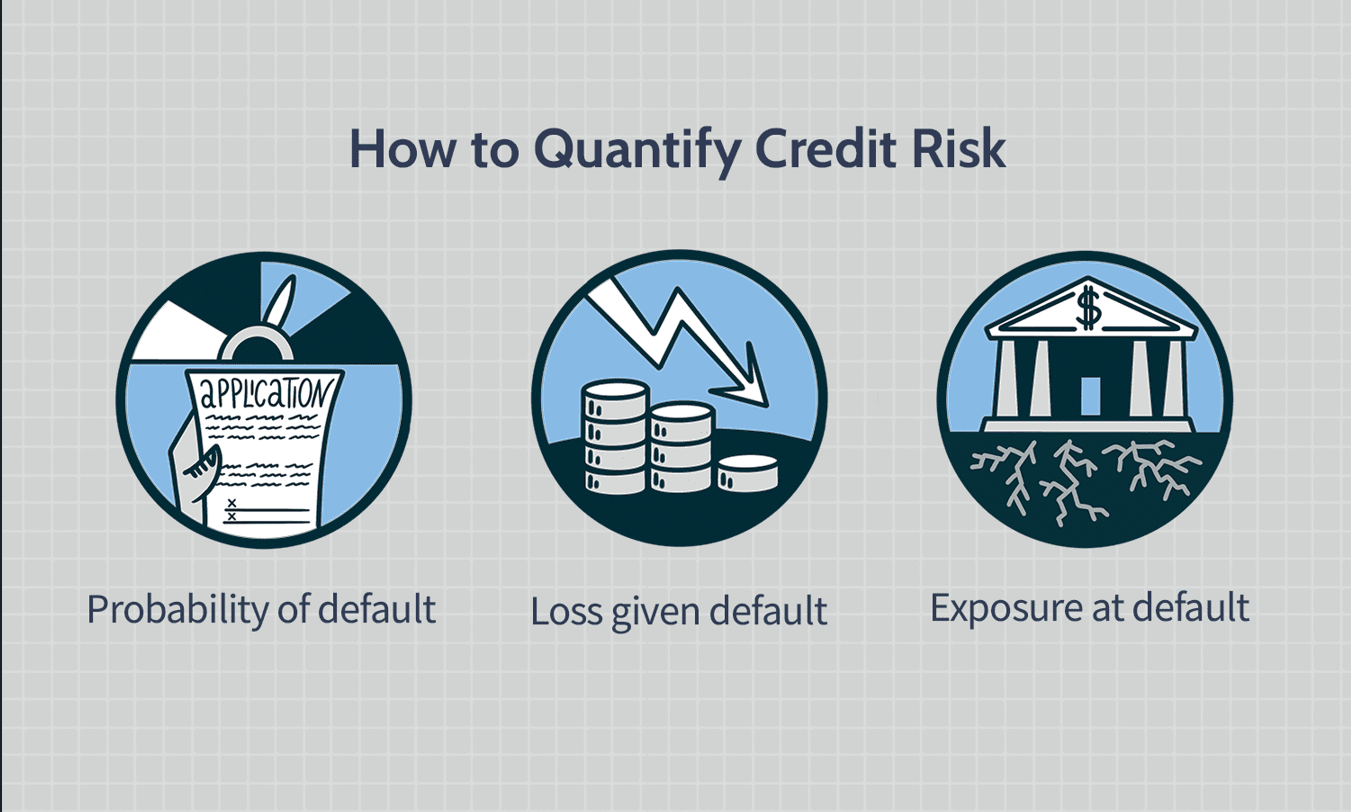</center>

# Introduction

When market actor decides to invest in an instrument or in a company on the stock market, he should't only take in account the expected return, but also the risk associated to his investment. There are a lot of measures and methods available to evaluate the risk associated to an investment decision depending on the data available and the degree of uncertainty we are ready to accept.

Using credit ratings data, we can model the loss coming from the incapacity of the obligors to respect their payments, namely the credit risk. Credit risk hold four components:

- **Probability of Default**: It is the relative frequency in the limit that a borrower will default on debt  over a one-year period. In other words, it provides the expected probability that customers fail to honor their debt. Ranging from 0% to 100% in percentage, a higher probability is asssociated to a higher likelihood to default.

- **Exposure at Default**: It is how much should we expect in dafault case, the amount exceeding to be. It represents the amount that the borrower has to pay  to the bank at the time of default

- **Loss given Default**: It gives how much the amount exceeding we expect to lose. It is proportional to the total exposure when borrower defaults. It is obtained using the formula (1- Recovery Rate):

$$
\begin{aligned}
LGD &= \frac{EAD-PV(recovery)-PV(cost)}{EAD}\\
PV(recovery)&= Present value of recovery discounted till time of default\\
PV(cost) &= Present value of cost discounted till time of default
\end{aligned}
$$

- **Effective Maturity**:  For fixed income securities with a mandatory redemption, call, tender or similar event
prior to the maturity date, it is the date of such future event. If no mandatory redemption, call, tender or
similar event is applicable to the security, it is generally the maturity date.

In this research, we are intending to estimate probability of default (PD) with US Issuer Credit Ratings data from 2008 to 2021 provided by [Standard & Poor](http://ratingshistory.info/) using two methods: Cohort Method, Hazard Method (one-year and multiple period horizon transition matrices); build confidence intervals for the probabilities estimated; to compare the confidence intervals;  assess if business cycles affect these estimates; and test for the monotonicity of the PD between ratings notch levels.

# Libraries and Setup

In [133]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [134]:
import os
os.chdir("/content/drive/MyDrive/CI for PD")

In [135]:
!pip install -q ydata-profiling

In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy import linalg as la
from ydata_profiling import ProfileReport
import datetime as dt
from sklearn.preprocessing import LabelEncoder

# Reading Data

In [137]:
sp_corporate_ratings = pd.read_csv("20220601 Standard & Poor's Ratings Services Corporate.csv")

# Basic EDA

In [138]:
profile = ProfileReport(sp_corporate_ratings, title="Profiling Report")

In [139]:
profile.to_notebook_iframe()

Output hidden; open in https://colab.research.google.com to view.

# Data Cleaning

In [140]:
(sp_corporate_ratings.isna().sum()/sp_corporate_ratings.shape[0])[sp_corporate_ratings.isna().sum()/sp_corporate_ratings.shape[0]>0.6]#.index.tolist() //delete those with more than 60% of missing data points

CUSIP_number                 0.895140
coupon_date                  1.000000
maturity_date                1.000000
par_value                    1.000000
rating_action_class          0.618760
rating_type_term             1.000000
watch_status                 0.811297
issuer_identifier            0.890503
issuer_identifier_schema     0.890503
central_index_key            0.918647
obligor_identifier           0.923024
obligor_identifier_schema    0.923024
obligor_identifier_other     1.000000
obligor_industry_group       1.000000
dtype: float64

After the above simple EDA, the following columns are missing more than 60% of their data:

**CUSIP_number** missing at 89.5%: The Committee on Uniform Security Identification Procedures was established by the American Bankers Association to develop a uniform method of identifying securities. CUSIP numbers are unique nine-character alphanumeric identifiers assigned to each series of securities. CUSIPs are assigned by CUSIP Global Services (CGS), the overarching entity representing all CUSIP global identification
offerings. CGS is managed on behalf of the American Bankers Association (ABA) by S&P Global Market
Intelligence’s CUSIP Service Bureau.

**coupon_date** missing at 100%: Date of payment of the coupon

**maturity_date** missing at 100%

**par_value** missing at 100%:  The principal amount of a security that appears on the face of
the instrument.

**rating_action_class** missing at 61.9%: The rating classification, new rating(NW), Upgrade of existing rating(UP), Downgrade(DG), Withdrwal for default(WD, the obligor defaulted, or the security or money market instrument went into default.), Withdrawal-Extinguished (WE, The obligation subject to the credit rating was extinguished by payment in full of all outstanding principal and interest due on the obligation according to the terms of the obligation.), Withdrawal-Other(WO, The credit rating was withdrawn for reasons other than Default or Extinguished.)

**rating_type_term** missing at 100%: The Rating Type Term; the NRSRO should use its own standard terminology. Example values: “short-term”, “long-term”.

**watch_status** missing at 81%: This item records watch list status such as Positive, Negative, Evolving, Developing, and Stable. The NRSRO should use its own standard terminology.

**issuer_identifier** missing at 89%: An Issuer Identifier in a scheme other than LEI or CIK and is used only when neither LEI nor CIK (The 10-digit Central Index Key (CIK) number of the Obligor, if available; it is used only when no LEI (The 20-character alphanumeric value Legal Entity Identifier issued by a utility endorsed or otherwise governed by the Global LEI Regulatory Oversight Committee or the Global LEI Foundation (LEI) to the Issuer, if available.) is available for the Obligor) of the Issuer is available.     

**issuer_identifier_schema** missing at 89%: obligor, DUNS(Dun & Bradstreet D-U-N-S® Number), BIC(Business Identifier Code (ISO 9362)), or NRSRO(Obligor or Issuer identifier scheme that is specific to the reporting NRSRO)

**central_index_key** missing at 92%: The 10-digit Central Index Key (CIK) number of the Issuer, if available; it is used only when no LEI is available for the Issuer

**obligor_identifier** missing at 92.3%: The content of this element is an Obligor Identifier in a scheme other than LEI or CIK; it is used only when neither LEI nor CIK is available for the Obligor.

**obligor_identifier_schema** missing at 92.3%: The scheme of the identifier in <OI>. This must be one of the allowed obligor or issuer identifier scheme values (see “Obligor or Issuer Identifier Scheme values).

**obligor_identifier_other** missing at 100%:

**obligor_industry_group** missing at  100%: Obligor Industry Group within the broad heading provided by the SEC Category or Subcategory. For example, an Obligor associated with the “Financial” SEC Category could be further identified as a “Bank”, “Broker” or another applicable identifier. The values used are the proprietary values used by the NRSRO.

In [141]:
(sp_corporate_ratings.isna().sum()/sp_corporate_ratings.shape[0])[sp_corporate_ratings.isna().sum()/sp_corporate_ratings.shape[0]<0.6]

rating_agency_name              0.000000
file_creating_date              0.000000
sec_category                    0.449765
issuer_name                     0.449765
legal_entity_identifier         0.267826
object_type_rated               0.449765
instrument_name                 0.449765
issued_paid                     0.000000
rating                          0.000000
rating_action_date              0.000000
rating_type                     0.000000
rating_sub_type                 0.000000
other_announcement_type         0.381240
rating_outlook                  0.543795
instrument_identifier           0.554625
instrument_identifier_schema    0.554625
obligor_sec_category            0.550235
obligor_name                    0.550235
dtype: float64

In [142]:
# Dropping columns with more than 60% of their values missing
missing_cols = (sp_corporate_ratings.isna().sum()/sp_corporate_ratings.shape[0])\
 [sp_corporate_ratings.isna().sum()/sp_corporate_ratings.shape[0]>0.6]\
 .index.tolist()

print(missing_cols)

sp_corporate_ratings.drop(missing_cols, axis=1, inplace=True)

['CUSIP_number', 'coupon_date', 'maturity_date', 'par_value', 'rating_action_class', 'rating_type_term', 'watch_status', 'issuer_identifier', 'issuer_identifier_schema', 'central_index_key', 'obligor_identifier', 'obligor_identifier_schema', 'obligor_identifier_other', 'obligor_industry_group']


In [143]:
# Dropping columns with constant values
constant_cols = sp_corporate_ratings.nunique()[sp_corporate_ratings.nunique()==1].index.tolist()

print(constant_cols)

sp_corporate_ratings.drop(constant_cols, axis=1, inplace=True) #same value for all rows

['rating_agency_name', 'file_creating_date', 'sec_category', 'instrument_identifier_schema', 'obligor_sec_category']


In [144]:
sp_corporate_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377626 entries, 0 to 377625
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   issuer_name              207783 non-null  object
 1   legal_entity_identifier  276488 non-null  object
 2   object_type_rated        207783 non-null  object
 3   instrument_name          207783 non-null  object
 4   issued_paid              377626 non-null  bool  
 5   rating                   377626 non-null  object
 6   rating_action_date       377626 non-null  object
 7   rating_type              377626 non-null  object
 8   rating_sub_type          377626 non-null  object
 9   other_announcement_type  233660 non-null  object
 10  rating_outlook           172275 non-null  object
 11  instrument_identifier    168185 non-null  object
 12  obligor_name             169843 non-null  object
dtypes: bool(1), object(12)
memory usage: 34.9+ MB


In [145]:
# sp_corporate_ratings.rating_sub_type.value_counts()

After keeping only non constant columns with no or less than 60% missing values, we have:

**issuer_name**: An issuer is a legal entity that develops, registers and sells securities to finance its operations. Issuers may be corporations, investment trusts, or domestic or foreign governments. Issuers make available securities such as equity shares, bonds, and warrants.

**legal_identity_identifier** missing at 26.78%: The 20-character alphanumeric value Legal Entity Identifier issued by a utility endorsed or otherwise governed by the Global LEI Regulatory Oversight Committee or the Global LEI Foundation (LEI) to the obligor, if available.

**object_type_rated** missing at 44.97%: rating(the rating applies to an instrument), program(the rating applies to a program), shelf(the rating applies to a shelf registration(it is a term used when the offerings are expected to occur on a future date but are registered beforehand by the company. It allows the issuing company to enter the securities market at a favorable and correct time without involving frequent documentation)),  other(The rating applies to an object other than instrument, program or shelf.)

**instrument_name** missing at 44.97%: The security or money market instrument name.

**issued_paid** having no missing values: it indicates wether or not the object issued has been paid.

**rating**: The Company rating.

**rating_action_date**: The date at which S&G gave the rating to the company.

**rating_type**: The rating type. The NRSRO should use its own standard terminology. Example values: “Bank Financial Strength”.

**rating_sub_type**: Sub type of the rating type used by the NRSRO. This is used to further classify a Rating Type if necessary.

**other_announcement_type** missing at 38.12%: The description of an Other Announcement type not classifiable under <RAC(Rating Action Classification)>, <WST(Watch Status)>, or <ROL(Rating Outlook)>. The NRSRO should use its own standard terminology. Example values: “Company name change”, “Affirm”.


**instrument_identifier** missing at 55.46%: An Instrument Identifier within a scheme other than CUSIP and is used only when a CUSIP is not available.

**obligor_name** missing at 55%:  The Obligor Name.

- Difference between an obligor and an issuer:

An **obligor**, also known as a debtor, is a person or entity who is legally or contractually obliged to provide a benefit or payment to another. In a financial context, the term "**obligor**" refers to a bond **issuer** who is contractually bound to make all principal repayments and interest payments on outstanding debt. The recipient of the benefit or payment is known as the obligee. (Investopedia)

The main difference between an issuer and obligor is that an issuer is the entity that creates and sells the security, while the obligor is the entity that is obligated to make payments on the security.

In most cases, the issuer and obligor are the same entity. However, there are some instances where the issuer and obligor are different entities. For example, when a company issues bonds, the company is the issuer, and the bondholders are the obligors.([infocomm](https://www.infocomm.ky/how-obligors-work/))

# Data Understanding and Visualization

In [146]:
sp_corporate_ratings[sp_corporate_ratings.obligor_name.isna()].issued_paid\
.value_counts(normalize=True)

True     0.998147
False    0.001853
Name: issued_paid, dtype: float64

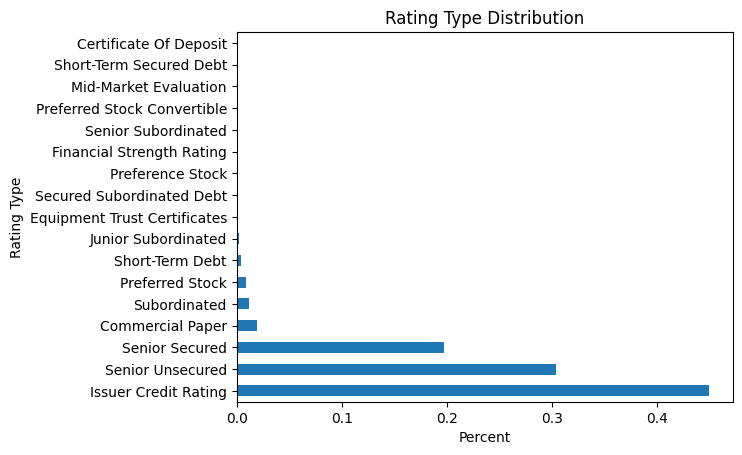

In [147]:
# ratings type horizontal barplot with bars labeled with percentage values at the edge
sp_corporate_ratings.rating_type.value_counts(normalize=True).plot(kind="barh")
plt.title("Rating Type Distribution")
plt.xlabel("Percent")
plt.ylabel("Rating Type")
plt.show()

In [148]:
sp_corporate_ratings[sp_corporate_ratings.rating_type=="Issuer Credit Rating"].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 169699 entries, 0 to 377609
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   issuer_name              0 non-null       object
 1   legal_entity_identifier  123278 non-null  object
 2   object_type_rated        0 non-null       object
 3   instrument_name          0 non-null       object
 4   issued_paid              169699 non-null  bool  
 5   rating                   169699 non-null  object
 6   rating_action_date       169699 non-null  object
 7   rating_type              169699 non-null  object
 8   rating_sub_type          169699 non-null  object
 9   other_announcement_type  109349 non-null  object
 10  rating_outlook           151437 non-null  object
 11  instrument_identifier    0 non-null       object
 12  obligor_name             169699 non-null  object
dtypes: bool(1), object(12)
memory usage: 17.0+ MB


In [149]:
issuer_credit_ratings = sp_corporate_ratings[sp_corporate_ratings.rating_type=="Issuer Credit Rating"]

In [150]:
issuer_credit_ratings_cleaned = issuer_credit_ratings.dropna(axis=1)
issuer_credit_ratings_cleaned["rating_outlook"] = issuer_credit_ratings.rating_outlook.fillna("Not Available")

<ipython-input-150-31ebe7b4e1aa>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  issuer_credit_ratings_cleaned["rating_outlook"] = issuer_credit_ratings.rating_outlook.fillna("Not Available")


# Data Preparation

In [151]:
issuer_credit_ratings_cleaned.rating_action_date = pd.to_datetime(issuer_credit_ratings_cleaned.rating_action_date)

<ipython-input-151-872692f60e46>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  issuer_credit_ratings_cleaned.rating_action_date = pd.to_datetime(issuer_credit_ratings_cleaned.rating_action_date)


In [152]:
issuer_credit_ratings_cleaned = issuer_credit_ratings_cleaned.sort_values(["obligor_name", "rating_action_date"])

In [153]:
# clean ratings
def clean_ratings(rating):
  # remove prelim, br, mx, cl, tw, ra, cn, ru za, ax, tr, gc, kz from rating
  rating = rating.replace("prelim", "")
  rating = rating.replace("br", "")
  rating = rating.replace("mx", "")
  rating = rating.replace("cl", "")
  rating = rating.replace("tw", "")
  rating = rating.replace("ra", "")
  rating = rating.replace("cn", "")
  rating = rating.replace("za", "")
  rating = rating.replace("ax", "")
  rating = rating.replace("tr", "")
  rating = rating.replace("gc", "")
  rating = rating.replace("kz", "")
  rating = rating.replace("ru", "")
  return rating

In [154]:
issuer_credit_ratings_cleaned.rating.apply(clean_ratings).unique()

array(['B+', 'BB-', 'BB', 'CCC+', 'B-', 'B', 'BBB+', 'A', 'A-', 'NR',
       'BBB', 'AA-', 'A-1+', 'A+', 'A-1', 'CCC', 'D', 'CC', 'SD', 'CCC-',
       'BB+', 'AA+', 'K-1', 'K-2', 'AAA', 'A-2', 'BBB-', 'A-3', 'AA', 'C',
       'B-1', 'BBB/A-2', 'BBB/NR', 'B-2'], dtype=object)

In [155]:
issuer_credit_ratings_cleaned.rating = issuer_credit_ratings_cleaned.rating.apply(clean_ratings)

In [156]:
# deleting dual ratings from data
dual_ratings = ['BBB/A-2', 'BBB/NR']
issuer_credit_ratings_cleaned = issuer_credit_ratings_cleaned[~issuer_credit_ratings_cleaned.rating.isin(dual_ratings)]

In [157]:
# Replacing SD(selective default) in ratings to D(default)
# issuer_credit_ratings_cleaned.rating = issuer_credit_ratings_cleaned.rating.replace("SD", "D")

In [158]:
# remove short-term ratings
short_term_ratings = ["A-1+", "A-1", "K-1", "K-2", "A-2", "A-3", "B-1"]
issuer_credit_ratings_cleaned = issuer_credit_ratings_cleaned[~issuer_credit_ratings_cleaned.rating.isin(short_term_ratings)]

In [159]:
companies_with_first_rating_as_NR = issuer_credit_ratings_cleaned.groupby("obligor_name")\
                                    .rating.first()[issuer_credit_ratings_cleaned\
                                    .groupby("obligor_name").rating.first()=="NR"]\
                                    .index.tolist()
companies_with_first_rating_as_NR

['AGC America, Inc.',
 'Autopistas del Sol S.A.',
 'Bezeq - Israel Telecommunication Corp. Ltd.',
 'Billing Services Group North America Inc.',
 'Compania De Inversiones de Energia S.A.',
 'Daimler Mexico S.A. de C.V.',
 'Danone Finance',
 'Ericsson Treasury Services AB',
 'Graceway Pharmaceuticals LLC',
 'Grunenthal GmbH',
 'Imcopa Importacao, Exportacao E Industria De Oleos S.A.',
 'LOCAP LLC',
 'Monitronics International Inc.',
 'PSE&G Fuel Corp.',
 'PT Arpeni Pratama Ocean Line Tbk.',
 "Perkins & Marie Callender's Inc.",
 'Sbarro LLC',
 'Telfer Investments S.L',
 'White Birch Paper Company']

In [160]:
issuer_credit_ratings_cleaned.loc[issuer_credit_ratings_cleaned.obligor_name.isin(companies_with_first_rating_as_NR)]

,issued_paid,rating,rating_action_date,rating_type,rating_sub_type,obligor_name,rating_outlook
162888,True,NR,2011-06-30,Issuer Credit Rating,Foreign Currency ST,"AGC America, Inc.",Not Available
162890,True,NR,2011-06-30,Issuer Credit Rating,Local Currency ST,"AGC America, Inc.",Not Available
185084,True,NR,2012-03-06,Issuer Credit Rating,Foreign Currency LT,Autopistas del Sol S.A.,Not Available
64740,True,NR,2011-06-21,Issuer Credit Rating,Foreign Currency LT,Bezeq - Israel Telecommunication Corp. Ltd.,Not Available
64741,True,NR,2011-06-21,Issuer Credit Rating,Local Currency LT,Bezeq - Israel Telecommunication Corp. Ltd.,Not Available
...,...,...,...,...,...,...,...
44985,True,NR,2014-03-14,Issuer Credit Rating,Local Currency LT,Sbarro LLC,NR
350758,True,NR,2019-08-28,Issuer Credit Rating,Foreign Currency Preliminary LT,Telfer Investments S.L,NR
350759,True,NR,2019-08-28,Issuer Credit Rating,Local Currency Preliminary LT,Telfer Investments S.L,NR
114174,True,NR,2011-09-09,Issuer Credit Rating,Foreign Currency LT,White Birch Paper Company,NR


In [161]:
issuer_credit_ratings_cleaned.duplicated().sum()

10

In [162]:
issuer_credit_ratings_cleaned.drop_duplicates(inplace=True)

<ipython-input-162-9c85be584993>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  issuer_credit_ratings_cleaned.drop_duplicates(inplace=True)


In [163]:
issuer_credit_ratings_cleaned.groupby(["obligor_name", "rating_action_date"]).rating.count()[issuer_credit_ratings_cleaned.groupby(["obligor_name", "rating_action_date"]).rating.count()!=1].value_counts()

2    74236
4     2294
3     2059
5       33
6       30
8        2
7        1
Name: rating, dtype: int64

In [164]:
issuer_credit_ratings_cleaned["ratings_count_by_obligor_and_date"] = issuer_credit_ratings_cleaned.groupby(["obligor_name", "rating_action_date"], as_index=False).rating.transform("count")

In [165]:
issuer_credit_ratings_cleaned[issuer_credit_ratings_cleaned.ratings_count_by_obligor_and_date!=1]

,issued_paid,rating,rating_action_date,rating_type,rating_sub_type,obligor_name,rating_outlook,ratings_count_by_obligor_and_date
31715,True,B+,2014-09-15,Issuer Credit Rating,Foreign Currency LT,1011778 B.C. Unlimited Liability Company,Stable,2
31726,True,B+,2014-09-15,Issuer Credit Rating,Local Currency LT,1011778 B.C. Unlimited Liability Company,Stable,2
31716,True,B+,2015-06-08,Issuer Credit Rating,Foreign Currency LT,1011778 B.C. Unlimited Liability Company,Stable,2
31727,True,B+,2015-06-08,Issuer Credit Rating,Local Currency LT,1011778 B.C. Unlimited Liability Company,Stable,2
31717,True,B+,2016-06-29,Issuer Credit Rating,Foreign Currency LT,1011778 B.C. Unlimited Liability Company,Stable,2
...,...,...,...,...,...,...,...,...
62547,True,BB,2014-08-18,Issuer Credit Rating,Local Currency LT,tw telecom inc.,Not Available,2
62536,True,BB-,2014-11-05,Issuer Credit Rating,Foreign Currency LT,tw telecom inc.,Stable,2
62548,True,BB-,2014-11-05,Issuer Credit Rating,Local Currency LT,tw telecom inc.,Stable,2
62537,True,NR,2015-02-17,Issuer Credit Rating,Foreign Currency LT,tw telecom inc.,NR,2


In [166]:
issuer_credit_ratings_cleaned[issuer_credit_ratings_cleaned.ratings_count_by_obligor_and_date!=1].rating_sub_type.value_counts()

Foreign Currency LT                     78615
Local Currency LT                       78595
Local Currency Preliminary LT            2062
Foreign Currency Preliminary LT          2060
Brazil National Scale LT                 1183
CaVal (Mexico) National Scale LT          353
Foreign Currency ST                       268
Local Currency ST                         267
Greater China Regional Scale LT           265
Taiwan National Scale LT                  179
Russia National Scale LT                  105
ASEAN Regional Scale LT                    96
Argentina National Scale LT                53
South Africa National Scale LT             28
CaVal (Mexico) National Scale ST           16
Brazil National Scale Preliminary LT        9
Turkey National Scale LT                    9
Kazakhstan National Scale LT                7
South Africa National Scale ST              6
Taiwan National Scale Preliminary LT        6
Chile National Scale LT                     5
Taiwan National Scale ST          

In [167]:
issuer_credit_ratings_cleaned_local_currency_lt = issuer_credit_ratings_cleaned[issuer_credit_ratings_cleaned.rating_sub_type=="Local Currency LT"]

In [168]:
issuer_credit_ratings_cleaned_local_currency_lt.rating.unique()

array(['B+', 'BB-', 'BB', 'CCC+', 'B-', 'B', 'BBB+', 'A', 'A-', 'NR',
       'BBB', 'AA-', 'A+', 'CCC', 'D', 'CC', 'SD', 'CCC-', 'BB+', 'BBB-',
       'AA', 'AAA', 'AA+'], dtype=object)

In [169]:
# deleting dual ratings from data
dual_ratings = ['BBB/A-2', 'BBB/NR']
issuer_credit_ratings_cleaned_local_currency_lt = issuer_credit_ratings_cleaned_local_currency_lt[~issuer_credit_ratings_cleaned_local_currency_lt.rating.isin(dual_ratings)]

# Replacing SD(selective default) in ratings to D(default)
issuer_credit_ratings_cleaned_local_currency_lt.rating = issuer_credit_ratings_cleaned_local_currency_lt.rating.replace("SD", "D")

In [170]:
# d_or_sd = issuer_credit_ratings_cleaned_local_currency_lt[issuer_credit_ratings_cleaned_local_currency_lt.rating.isin(["SD", "D"])].sort_values(["obligor_name", 'rating_action_date'])

In [171]:
# d_or_sd[d_or_sd.obligor_name.isin(d_or_sd.groupby("obligor_name")["rating"].count()[d_or_sd.groupby("obligor_name")["rating"].count()!=1].index.tolist())]

In [172]:
issuer_credit_ratings_cleaned_local_currency_lt.duplicated().sum()

0

In [173]:
issuer_credit_ratings_cleaned_local_currency_lt.obligor_name.nunique()

8534

In [174]:
issuer_credit_ratings_cleaned_local_currency_lt.rating.value_counts().sort_index()

A        2877
A+       1519
A-       4835
AA        392
AA+        98
AA-      1046
AAA       146
B       12189
B+       7355
B-       6365
BB       4741
BB+      4090
BB-      5630
BBB      6728
BBB+     5536
BBB-     6090
CC        486
CCC      1090
CCC+     2382
CCC-      648
D         980
NR       3587
Name: rating, dtype: int64

In [175]:
# issuer_credit_ratings_cleaned_local_currency_lt.groupby("obligor_name").rating.apply(list)[issuer_credit_ratings_cleaned_local_currency_lt.groupby("obligor_name").rating.apply(list).apply(lambda x: x.index("D")>x.index("NR") if(("D" in x) and ("NR" in x)) else False)]

In [176]:
# companies_transitionning_to_nr_before_D =  issuer_credit_ratings_cleaned_local_currency_lt.groupby("obligor_name").rating.apply(list)[issuer_credit_ratings_cleaned_local_currency_lt.groupby("obligor_name").rating.apply(list).apply(lambda x: x.index("D")>x.index("NR") if(("D" in x) and ("NR" in x)) else False)].index.tolist()
# companies_transitionning_to_nr_before_D

In [177]:
# issuer_credit_ratings_cleaned_local_currency_lt[issuer_credit_ratings_cleaned_local_currency_lt.obligor_name.isin(companies_transitionning_to_nr_before_D)]

In [178]:
# issuer_credit_ratings_cleaned_local_currency_lt = issuer_credit_ratings_cleaned_local_currency_lt[~issuer_credit_ratings_cleaned_local_currency_lt.obligor_name.isin(companies_transitionning_to_nr_before_D)]

In [179]:
issuer_credit_ratings_cleaned_local_currency_lt.rating_outlook.value_counts()

Stable           47620
Negative         14723
Not Available     6985
Positive          4748
NR                3565
NM                 793
Developing         376
Name: rating_outlook, dtype: int64

In [180]:
issuer_credit_ratings_cleaned_local_currency_lt["ratings_count_by_obligor_and_date"] = issuer_credit_ratings_cleaned_local_currency_lt.groupby(["obligor_name", "rating_action_date"], as_index=False).rating.transform("count")

In [181]:
issuer_credit_ratings_cleaned_local_currency_lt.ratings_count_by_obligor_and_date.value_counts()

1    76366
2     2444
Name: ratings_count_by_obligor_and_date, dtype: int64

In [182]:
companies_with_two_ratings_whose_one_is_nr_row_index = issuer_credit_ratings_cleaned_local_currency_lt[((issuer_credit_ratings_cleaned_local_currency_lt.ratings_count_by_obligor_and_date!=1) & (issuer_credit_ratings_cleaned_local_currency_lt.rating=="NR"))].index.tolist()

In [183]:
# dropping companies with two ratings whose one is NR
issuer_credit_ratings_cleaned_local_currency_lt.drop(companies_with_two_ratings_whose_one_is_nr_row_index, inplace=True)

In [184]:
issuer_credit_ratings_cleaned_local_currency_lt["ratings_count_by_obligor_and_date"] = issuer_credit_ratings_cleaned_local_currency_lt.groupby(["obligor_name", "rating_action_date"], as_index=False).rating.transform("count")

In [185]:
issuer_credit_ratings_cleaned_local_currency_lt[issuer_credit_ratings_cleaned_local_currency_lt.ratings_count_by_obligor_and_date!=1]

,issued_paid,rating,rating_action_date,rating_type,rating_sub_type,obligor_name,rating_outlook,ratings_count_by_obligor_and_date
31839,True,BB-,2014-05-29,Issuer Credit Rating,Local Currency LT,AmSurg Corp.,Stable,2
31840,True,BB-,2014-05-29,Issuer Credit Rating,Local Currency LT,AmSurg Corp.,Not Available,2
337743,True,D,2012-06-22,Issuer Credit Rating,Local Currency LT,Central European Media Enterprises Ltd.,NM,2
337744,True,B-,2012-06-22,Issuer Credit Rating,Local Currency LT,Central European Media Enterprises Ltd.,Stable,2
344134,True,D,2014-07-03,Issuer Credit Rating,Local Currency LT,"Corporate Risk Holdings, LLC",NM,2
344135,True,CCC+,2014-07-03,Issuer Credit Rating,Local Currency LT,"Corporate Risk Holdings, LLC",Negative,2
239828,True,D,2017-08-28,Issuer Credit Rating,Local Currency LT,MIE Holdings Corporation,NM,2
239829,True,CCC-,2017-08-28,Issuer Credit Rating,Local Currency LT,MIE Holdings Corporation,Negative,2
250088,True,BB-,2020-05-15,Issuer Credit Rating,Local Currency LT,OSI Restaurant Partners LLC,Not Available,2
250089,True,B+,2020-05-15,Issuer Credit Rating,Local Currency LT,OSI Restaurant Partners LLC,Negative,2


In [186]:
issuer_credit_ratings_cleaned_local_currency_lt.columns

Index(['issued_paid', 'rating', 'rating_action_date', 'rating_type',
       'rating_sub_type', 'obligor_name', 'rating_outlook',
       'ratings_count_by_obligor_and_date'],
      dtype='object')

In [187]:
issuer_credit_ratings_cleaned_local_currency_lt[issuer_credit_ratings_cleaned_local_currency_lt.duplicated(subset=['issued_paid', 'rating', 'rating_action_date', 'rating_type',
                                                                   'rating_sub_type', 'obligor_name', 'ratings_count_by_obligor_and_date'])]

,issued_paid,rating,rating_action_date,rating_type,rating_sub_type,obligor_name,rating_outlook,ratings_count_by_obligor_and_date
31840,True,BB-,2014-05-29,Issuer Credit Rating,Local Currency LT,AmSurg Corp.,Not Available,2


In [188]:
issuer_credit_ratings_cleaned_local_currency_lt.drop(31840, inplace=True)

In [189]:
issuer_credit_ratings_cleaned_local_currency_lt["ratings_count_by_obligor_and_date"] = issuer_credit_ratings_cleaned_local_currency_lt.groupby(["obligor_name", "rating_action_date"], as_index=False).rating.transform("count")

In [190]:
issuer_credit_ratings_cleaned_local_currency_lt[issuer_credit_ratings_cleaned_local_currency_lt.ratings_count_by_obligor_and_date!=1][issuer_credit_ratings_cleaned_local_currency_lt[issuer_credit_ratings_cleaned_local_currency_lt.ratings_count_by_obligor_and_date!=1].rating_outlook=="NM"]

,issued_paid,rating,rating_action_date,rating_type,rating_sub_type,obligor_name,rating_outlook,ratings_count_by_obligor_and_date
337743,True,D,2012-06-22,Issuer Credit Rating,Local Currency LT,Central European Media Enterprises Ltd.,NM,2
344134,True,D,2014-07-03,Issuer Credit Rating,Local Currency LT,"Corporate Risk Holdings, LLC",NM,2
239828,True,D,2017-08-28,Issuer Credit Rating,Local Currency LT,MIE Holdings Corporation,NM,2


In [191]:
issuer_credit_ratings_cleaned_local_currency_lt.drop([337743, 344134, 239828], axis=0, inplace=True)

In [192]:
issuer_credit_ratings_cleaned_local_currency_lt["ratings_count_by_obligor_and_date"] = issuer_credit_ratings_cleaned_local_currency_lt.groupby(["obligor_name", "rating_action_date"], as_index=False).rating.transform("count")

In [193]:
issuer_credit_ratings_cleaned_local_currency_lt[issuer_credit_ratings_cleaned_local_currency_lt.ratings_count_by_obligor_and_date!=1]

,issued_paid,rating,rating_action_date,rating_type,rating_sub_type,obligor_name,rating_outlook,ratings_count_by_obligor_and_date
250088,True,BB-,2020-05-15,Issuer Credit Rating,Local Currency LT,OSI Restaurant Partners LLC,Not Available,2
250089,True,B+,2020-05-15,Issuer Credit Rating,Local Currency LT,OSI Restaurant Partners LLC,Negative,2
3980,True,B-,2013-08-05,Issuer Credit Rating,Local Currency LT,PT Bumi Resources Tbk.,Not Available,2
3981,True,CCC,2013-08-05,Issuer Credit Rating,Local Currency LT,PT Bumi Resources Tbk.,Not Available,2


In [194]:
issuer_credit_ratings_cleaned_local_currency_lt.drop([250088, 3980], axis=0, inplace=True)

In [195]:
issuer_credit_ratings_cleaned_local_currency_lt.drop(["ratings_count_by_obligor_and_date", "rating_sub_type", "rating_type", "issued_paid"], axis=1, inplace=True)

In [196]:
issuer_credit_ratings_cleaned_local_currency_lt.reset_index(drop=True, inplace=True)

In [197]:
issuer_credit_ratings_cleaned_local_currency_lt

,rating,rating_action_date,obligor_name,rating_outlook
0,B+,2014-09-15,1011778 B.C. Unlimited Liability Company,Stable
1,B+,2015-06-08,1011778 B.C. Unlimited Liability Company,Stable
2,B+,2016-06-29,1011778 B.C. Unlimited Liability Company,Stable
3,B+,2017-02-14,1011778 B.C. Unlimited Liability Company,Stable
4,B+,2017-02-24,1011778 B.C. Unlimited Liability Company,Stable
...,...,...,...,...
77583,BB,2013-12-10,tw telecom inc.,Stable
77584,BB,2014-06-16,tw telecom inc.,Not Available
77585,BB,2014-08-18,tw telecom inc.,Not Available
77586,BB-,2014-11-05,tw telecom inc.,Stable


In [198]:
issuer_credit_ratings_cleaned_local_currency_lt.groupby("obligor_name")["rating"].first()[issuer_credit_ratings_cleaned_local_currency_lt.groupby("obligor_name")["rating"].first()=="NR"]

obligor_name
Bezeq - Israel Telecommunication Corp. Ltd.                NR
Billing Services Group North America Inc.                  NR
Graceway Pharmaceuticals LLC                               NR
Imcopa Importacao, Exportacao E Industria De Oleos S.A.    NR
Monitronics International Inc.                             NR
PT Arpeni Pratama Ocean Line Tbk.                          NR
Perkins & Marie Callender's Inc.                           NR
Sbarro LLC                                                 NR
White Birch Paper Company                                  NR
Name: rating, dtype: object

In [199]:
companies_whose_first_rating_is_nr = issuer_credit_ratings_cleaned_local_currency_lt.groupby("obligor_name")["rating"].first()[issuer_credit_ratings_cleaned_local_currency_lt.groupby("obligor_name")["rating"].first()=="NR"].index.tolist()
companies_whose_first_rating_is_nr

['Bezeq - Israel Telecommunication Corp. Ltd.',
 'Billing Services Group North America Inc.',
 'Graceway Pharmaceuticals LLC',
 'Imcopa Importacao, Exportacao E Industria De Oleos S.A.',
 'Monitronics International Inc.',
 'PT Arpeni Pratama Ocean Line Tbk.',
 "Perkins & Marie Callender's Inc.",
 'Sbarro LLC',
 'White Birch Paper Company']

In [200]:
issuer_credit_ratings_cleaned_local_currency_lt_nr_first = issuer_credit_ratings_cleaned_local_currency_lt[issuer_credit_ratings_cleaned_local_currency_lt.obligor_name.isin(companies_whose_first_rating_is_nr)]

In [201]:
def mask_first(x):
  # https://stackoverflow.com/questions/31226142/python-pandas-delete-the-first-row-by-group
  result = np.ones_like(x)
  result[0] = 0
  return result

mask = issuer_credit_ratings_cleaned_local_currency_lt_nr_first.groupby(['obligor_name'])['obligor_name'].transform(mask_first).astype(bool)
print(issuer_credit_ratings_cleaned_local_currency_lt_nr_first.loc[mask])

      rating rating_action_date                    obligor_name rating_outlook
44691      B         2012-04-11  Monitronics International Inc.         Stable
44692      B         2013-02-08  Monitronics International Inc.         Stable
44693      B         2013-07-11  Monitronics International Inc.         Stable
44694      B         2014-02-28  Monitronics International Inc.         Stable
44695      B         2015-02-10  Monitronics International Inc.         Stable
44696      B         2015-08-13  Monitronics International Inc.       Negative
44697      B         2016-02-18  Monitronics International Inc.       Negative
44698     B-         2016-09-08  Monitronics International Inc.         Stable
44699     B-         2017-02-17  Monitronics International Inc.         Stable
44700     B-         2018-02-12  Monitronics International Inc.       Negative
44701    CCC         2018-08-03  Monitronics International Inc.       Negative
44702     CC         2018-09-04  Monitronics Interna

In [202]:
issuer_credit_ratings_cleaned_local_currency_lt_nr_first_cleaned = issuer_credit_ratings_cleaned_local_currency_lt_nr_first.loc[mask]

In [203]:
issuer_credit_ratings_cleaned_local_currency_lt = pd.concat([
    issuer_credit_ratings_cleaned_local_currency_lt[~issuer_credit_ratings_cleaned_local_currency_lt.obligor_name.isin(companies_whose_first_rating_is_nr)],
    issuer_credit_ratings_cleaned_local_currency_lt_nr_first_cleaned
])

In [204]:
issuer_credit_ratings_cleaned_local_currency_lt.groupby("obligor_name")["rating"].first()[issuer_credit_ratings_cleaned_local_currency_lt.groupby("obligor_name")["rating"].first()=="NR"]

Series([], Name: rating, dtype: object)

In [205]:
os.listdir()

['confidence_intervals_finance.pdf',
 "20220601 Standard & Poor's Ratings Services Corporate.csv",
 'synthetic_data6.csv',
 'Nts.csv',
 'TransitionData.csv',
 'Data',
 'Notebooks',
 'recession_expantion.csv',
 'recession_expantion.ipynb',
 'ratings_mapping_reduced.csv',
 'pij_reduced.csv',
 'Credit Risk Modeling.ipynb',
 'wald_ci.csv',
 'table.csv',
 'agresti_ci_df.csv',
 'clopper_ci_df.csv',
 'boot_ci.csv',
 'Ratings modified.ipynb',
 'pds_2015_1000.csv',
 'Confidence Intervals_bootstrap_param_2015.ipynb',
 'pds_2014_1000.csv',
 'Confidence Intervals_bootstrap_param_2014.ipynb',
 'pds_2016_1000.csv',
 'Confidence Intervals_bootstrap_param_2016.ipynb',
 'Confidence Intervals_bootstrap_param_2011.ipynb',
 'Confidence Intervals_bootstrap_param_2012.ipynb',
 'pds_2021_1000.csv',
 'Confidence Intervals_bootstrap_param_2021.ipynb',
 'Confidence Intervals_bootstrap_param_2018.ipynb',
 'Confidence Intervals_bootstrap_param_2020.ipynb',
 'Confidence Intervals_bootstrap_param_2019.ipynb',
 'Con

In [206]:
# issuer_credit_ratings_cleaned_local_currency_lt = issuer_credit_ratings_cleaned_local_currency_lt[issuer_credit_ratings_cleaned_local_currency_lt.rating_action_date>="2011-01-01"]

In [207]:
# saving data
issuer_credit_ratings_cleaned_local_currency_lt.to_csv("issuer_credit_ratings_cleaned_local_currency_lt.csv", index=False)

In [208]:
print(sorted(issuer_credit_ratings_cleaned_local_currency_lt.rating.unique()))

['A', 'A+', 'A-', 'AA', 'AA+', 'AA-', 'AAA', 'B', 'B+', 'B-', 'BB', 'BB+', 'BB-', 'BBB', 'BBB+', 'BBB-', 'CC', 'CCC', 'CCC+', 'CCC-', 'D', 'NR']


In [209]:
issuer_credit_ratings_cleaned_local_currency_lt.rating.nunique()

22

In [210]:
ratings_mapping = pd.DataFrame({
    "RatingSymbol": ["AAA", "AA+", "AA", "AA-", "A+", "A", "A-", "BBB+",
                     "BBB", "BBB-", "BB+", "BB", "BB-", "B+", "B", "B-",
                     "CCC+", "CCC", "CCC-", "CC", "D", "NR"],
    "RatingNumber": [i for i in range(len(["AAA", "AA+", "AA", "AA-", "A+", "A", "A-", "BBB+",
                      "BBB", "BBB-", "BB+", "BB", "BB-", "B+", "B", "B-",
                     "CCC+", "CCC", "CCC-", "CC", "D", "NR"]))]
})
ratings_mapping.tail()

,RatingSymbol,RatingNumber
17,CCC,17
18,CCC-,18
19,CC,19
20,D,20
21,NR,21


In [211]:
ratings_mapping.to_csv("ratings_mapping.csv", index=False)

# Probability of Default Estimate

## Data Structures

In [212]:
# https://github.com/dpicone1/Estimating_Credit_Rating_Transition_Matrices_Hazard_Vs_Cohort/blob/master/TransitionClassFile.py
# the default rating symbol is D
# the default rating index  is 20

# the NR rating symbol is NR
# the NR rating index  is 21

# There are 21 initial states AAA, AA+, AA, AA-, A+, A, A-, BBB+, BBB, BBB-, BB+,
#                            BB, BB-, B+, B, B-, CCC+, CCC, CCC-, CC, D
# and 22 final states         AAA, AA+, AA, AA-, A+, A, A-, BBB+, BBB, BBB-, BB+,
#                            BB, BB-, B+, B, B-, CCC+, CCC, CCC-, CC, D, NR

class TransitionClass(object):
    def __init__(self, Dati, yend):

        #Dati is a dataframe containing the info to be processed
        #yend  is final year of the analysis
        self.MyDati = Dati
        self.MyDati = self.MyDati.copy()

        self.MyDati['Year']     = pd.DatetimeIndex(self.MyDati['Date']).year
        self.MyDati['TimeDiff'] = self.MyDati['Date'].diff()

        self.defautYes = False #The general status is that the loan/bond has not defaulted for the cohort model
        self.NRYes     = False #The general status is that the loan/bond is not NR for the cohort model

        self.DefaultedCheck()# check if the data contains a default
        self.NRCheck()       # check if the data contains a NR

        self.size      = len(self.MyDati)
        self.yend      = yend
        self.ybeg      = (self.MyDati.iloc[0].Date).year


    def DefaultedCheck(self):
        # Is there a default?
        self.defaulted     = self.MyDati[self.MyDati['RatingSymbol'] == 'D']
        self.defaultedSize = len(self.defaulted)

        if (self.defaultedSize > 0):

            # remove all the data after the obligor has defaulted
            DefaultDate = self.MyDati[self.MyDati['RatingSymbol'] == 'D']
            date = DefaultDate.iloc[0].Date
            self.MyDati = self.MyDati.drop(self.MyDati[self.MyDati['Date'] > date].index)

            # After removing all addtional data after defaut,
            # we should have only one defaulted record, the first one
            self.defaulted     = self.MyDati[self.MyDati['RatingSymbol'] == 'D']
            self.defaultedSize = len(self.defaulted)
            self.defaultyear = self.defaulted.iloc[0].Year
            self.defaultYes  = True

    def NRCheck(self):
        # Is there a NR without a previous Default?
        self.NRSize = 0
        self.NR     = self.MyDati[self.MyDati['RatingSymbol'] == 'NR']

        if (len(self.NR) > 0 & self.defaultedSize == 1): # Remove the NR record. We do not need it as we stop
            # as soon as the borrower defaults
            self.MyDati = self.MyDati.drop(self.MyDati[self.MyDati['RatingSymbol'] == 'NR'].index)

        if (len(self.NR) > 0 & self.defaultedSize == 0): # only if there is no default, otherwise the default will
            # overseed and stop the algo as soon as there is a default event

            # The obligor might have several NR or after an NR status might come a rating from AAA to C.
            # We remove all the data after the first NR.

            NRDate = self.MyDati[self.MyDati['RatingSymbol'] == 'NR']
            date = NRDate.iloc[0].Date
            self.MyDati = self.MyDati.drop(self.MyDati[self.MyDati['Date'] > date].index)

            # After removing all addtional NR, we should have only one NR record, the oldest one
            self.NR     = self.MyDati[self.MyDati['RatingSymbol'] == 'NR']
            self.NRSize = len(self.NR)
            self.NRyear = self.NR.iloc[0].Year
            self.NRYes  = True

    def Cohort(self):

        self.RatingsBeg = [self.MyDati.iloc[0].RatingSymbol] # containing the rating symbol at the beginning of the period
        self.RatingsEnd = []                                 # containing the rating symbol at the end of the period

        self.RatingsBegIndex = [self.MyDati.iloc[0].RatingNumber]# containing the rating index at the beginning of the period
        self.RatingsEndIndex = []                                # containing the rating index at the end of the period

        if   (self.defaultedSize == 1):
            finalYear = min(self.yend, self.defaultyear)
        elif (self.NRSize > 0):
            finalYear = min(self.yend, self.NRyear)
        else:
            finalYear = self.yend

        for i in range(self.ybeg, finalYear + 1):

            self.MyDatiLoop = self.MyDati[self.MyDati['Year'] == i]

            if(len(self.MyDatiLoop) > 0):
                dateCond         = max(self.MyDatiLoop.Date)
                self.MyDatiLoop2 = self.MyDatiLoop[self.MyDatiLoop['Date'] == dateCond]
                self.RatingsEnd.append(self.MyDatiLoop2.iloc[0].RatingSymbol)
                self.RatingsEndIndex.append(self.MyDatiLoop2.iloc[0].RatingNumber)

            else:
                self.RatingsEnd.append(self.MyDatiLoop2.iloc[0].RatingSymbol)
                self.RatingsEndIndex.append(self.MyDatiLoop2.iloc[0].RatingNumber)

            self.RatingsBeg.append(self.MyDatiLoop2.iloc[0].RatingSymbol)
            self.RatingsBegIndex.append(self.MyDatiLoop2.iloc[0].RatingNumber)

            if(self.RatingsEnd[-1] == 'D' or self.RatingsEnd[-1] == 'NR' ):
                break

        if(self.defautYes):
            self.RatingsEnd[-1]      = 'D'
            self.RatingsEndIndex[-1] = 20

        if(self.NRYes):
            self.RatingsEnd[-1]      = 'NR'
            self.RatingsEndIndex[-1] = 21

        self.RatingsBeg      = self.RatingsBeg[:-1]
        self.RatingsBegIndex = self.RatingsBegIndex[:-1]

    def CohortTransitionMatrix(self):
        self.TransMatrix = np.zeros([21, 22])
        self.TransDen    = np.zeros([21])

        for i in range(len(self.RatingsEndIndex)):
            self.TransMatrix[self.RatingsBegIndex[i], self.RatingsEndIndex[i]] +=1
            self.TransDen[self.RatingsBegIndex[i]] +=1

    def HazardModel(self):

        self.TransDenLambda  = np.zeros([21]) # containing the denominator Hazard Model

        self.DefaultYesHazard = False

        for i in range(1, self.size):

            valore = self.MyDati.iloc[i].TimeDiff.days / 365
            self.TransDenLambda[self.MyDati.iloc[i - 1].RatingNumber] += valore

            if (self.MyDati.iloc[i].RatingSymbol == 'D' or self.MyDati.iloc[i].RatingSymbol == 'NR'):
                self.DefaultYesHazard = True
                break

        #first period
        dbeg = dt.date(self.MyDati.iloc[0].Year, 1, 1)
        valoreBeg = (self.MyDati.iloc[0].Date - dbeg).days/365.0
        self.TransDenLambda[self.MyDati.iloc[0].RatingNumber] += valoreBeg

        # Last Period Analysis
        dfinal = dt.date(self.yend, 12, 31)
        if(self.DefaultYesHazard == False):
            valoreEnd = (dfinal - self.MyDati.iloc[self.size - 1].Date).days/365.0
            self.TransDenLambda[self.MyDati.iloc[self.size - 1].RatingNumber] += valoreEnd

In [213]:
TransitionData = issuer_credit_ratings_cleaned_local_currency_lt[["obligor_name", "rating_action_date", "rating"]]
TransitionData.columns = ["Id", "Date", "RatingSymbol"]
TransitionData = TransitionData.sort_values(by=["Id", "Date"])
le = LabelEncoder()
TransitionData.Id = le.fit_transform(TransitionData.Id)
print (TransitionData.head(2))
print ("---------------------------")
print (TransitionData.tail(2))
size = len(TransitionData)

   Id       Date RatingSymbol
0   0 2014-09-15           B+
1   0 2015-06-08           B+
---------------------------
         Id       Date RatingSymbol
77586  8526 2014-11-05          BB-
77587  8526 2015-02-17           NR


In [214]:
print (TransitionData.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77579 entries, 0 to 77587
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Id            77579 non-null  int64         
 1   Date          77579 non-null  datetime64[ns]
 2   RatingSymbol  77579 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.4+ MB
None


In [215]:
print (TransitionData.dtypes)

Id                       int64
Date            datetime64[ns]
RatingSymbol            object
dtype: object


In [216]:
MappingData = ratings_mapping
MappingData.columns = ["RatingSymbol", "RatingNumber"]
MappingData = MappingData.sort_values(by=["RatingNumber"])
print (MappingData.head(2))
print ("---------------------------")
print (MappingData.tail(2))

  RatingSymbol  RatingNumber
0          AAA             0
1          AA+             1
---------------------------
   RatingSymbol  RatingNumber
20            D            20
21           NR            21


In [217]:
TransitionData = pd.merge(TransitionData, MappingData, on='RatingSymbol', how='left')
TransitionData.head()

,Id,Date,RatingSymbol,RatingNumber
0,0,2014-09-15,B+,13
1,0,2015-06-08,B+,13
2,0,2016-06-29,B+,13
3,0,2017-02-14,B+,13
4,0,2017-02-24,B+,13


In [218]:
ystart = min(TransitionData.Date)
ystart = ystart.year
ystart

2008

In [219]:
yend = max(TransitionData.Date)
yend = yend.year
yend

2021

In [220]:
classes = max(TransitionData.RatingNumber)
classes

21

In [221]:
size = len(TransitionData)
size

77579

In [222]:
obs = len(TransitionData)
obs

77579

In [223]:
TransitionData['Date'] = TransitionData['Date'].dt.date

## Let's test the TransitionClass

In [224]:
# Use the Id number 7 and 11 to get used to the outputs
# for the obligor with Id 7
ObligorID = 5586 # type 11 next time
MyDati = TransitionData[TransitionData['Id'] == ObligorID]
MyDati = MyDati.copy()
MyDati

,Id,Date,RatingSymbol,RatingNumber
50409,5586,2010-12-16,BB,11
50410,5586,2011-09-28,NR,21
50411,5586,2019-04-26,BB+,10
50412,5586,2020-03-20,BB+,10
50413,5586,2020-08-27,BB+,10


In [225]:
example1 = TransitionClass(MyDati, yend)
example1.Cohort()
example1.CohortTransitionMatrix()
example1.HazardModel()

In [226]:
# We print the ratings symbols at the beginning and at the end of each year respectively
print(example1.RatingsBeg)
print(example1.RatingsEnd)

['BB', 'BB']
['BB', 'NR']


In [227]:
# We print the denominator array, which counts the number of positions at the beginning of each year
# The position 1 corresponds to AAA, position 2 to AA, and the last one is Defaut
print(example1.TransDen)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [228]:
# The sum of TransDen is the total of years under investigation for this obligor
print(sum(example1.TransDen))

2.0


In [229]:
# We print the transition matrix, which counts the number of transits from one rating (row) to another rating (column)
print(example1.TransMatrix)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [230]:
# TransDenLambda is the denominator for the hazard method.
print("Hazard: ", example1.TransDenLambda)
print("----------------")
print("Cohort: ", example1.TransDen)

Hazard:  [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         1.73972603
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]
----------------
Cohort:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [231]:
# The sum of TransDenLambda should again be equal to the sum of TransDen.
# Not exactly the same, as the time spent in each rating class is divided by 365.
# To be excact we should have used the exact number of days in each year (2000 and 2004 are leap years)
print(sum(example1.TransDenLambda))
print(sum(example1.TransDen))

1.7397260273972601
2.0


## Let's run the TransitionClass() on all data available!

In [232]:
maxID = TransitionData.iloc[size-1].Id
maxID

8526

In [233]:
# The arrays containing the outputs
TransMatrixResults       = np.zeros([21, 22])
TransDenResults          = np.zeros([21])
TransDenLambdaResults    = np.zeros([21])

In [234]:
# Run the algo for all obligors
for i in range(1, maxID + 1):

    MyDati = TransitionData[TransitionData['Id'] == i]
    print ("processing ID borrower No: ", i)

    if (len(MyDati) == 1 and MyDati.iloc[0].RatingSymbol == 'NR'):
        # when this is true the data is not processed as it contains only one record, equal to state NR
        print("Only one NR Rating event on Borrower No: ", i)

    else:
        trans = TransitionClass(MyDati, yend)
        trans.Cohort()
        trans.CohortTransitionMatrix()
        trans.HazardModel()

        TransMatrixResults    = trans.TransMatrix + TransMatrixResults
        TransDenResults       = trans.TransDen    + TransDenResults
        TransDenLambdaResults = trans.TransDenLambda + TransDenLambdaResults

Streaming output truncated to the last 5000 lines.
processing ID borrower No:  3527
processing ID borrower No:  3528
processing ID borrower No:  3529
processing ID borrower No:  3530
processing ID borrower No:  3531
processing ID borrower No:  3532
processing ID borrower No:  3533
processing ID borrower No:  3534
processing ID borrower No:  3535
processing ID borrower No:  3536
processing ID borrower No:  3537
processing ID borrower No:  3538
processing ID borrower No:  3539
processing ID borrower No:  3540
processing ID borrower No:  3541
processing ID borrower No:  3542
processing ID borrower No:  3543
processing ID borrower No:  3544
processing ID borrower No:  3545
processing ID borrower No:  3546
processing ID borrower No:  3547
processing ID borrower No:  3548
processing ID borrower No:  3549
processing ID borrower No:  3550
processing ID borrower No:  3551
processing ID borrower No:  3552
processing ID borrower No:  3553
processing ID borrower No:  3554
processing ID borrower No

In [235]:
TransDenResults

array([  138.,    87.,   366.,   865.,  1430.,  2590.,  4145.,  4858.,
        6055.,  5068.,  3406.,  3990.,  4614.,  6054., 10953.,  4865.,
        1236.,   496.,   247.,   145.,     0.])

In [236]:
TransDenLambdaResults

array([  133.60547945,    87.        ,   354.24383562,   841.88493151,
        1402.48767123,  2598.98356164,  4132.31780822,  4852.58082192,
        6055.08767123,  4985.28493151,  3408.77808219,  3919.45205479,
        4504.49041096,  5755.66849315, 10239.53972603,  4803.07123288,
        1323.03561644,   502.45479452,   250.41369863,   150.89589041,
           0.        ])

In [237]:
# In case you need to see the transitions
TransMatrixResults
pij = pd.DataFrame(TransMatrixResults)
pij.to_csv('pij.csv')

In [238]:
TransMatrixResults

array([[1.290e+02, 8.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 7.700e+01, 7.000e+00, 3.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 3.000e+00, 3.160e+02, 3.800e+01, 3.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 4.000e+00],
       [0.000e+00, 0.000e+00, 2.700e+01, 7.290e+02, 8.200e+01, 1.500e+01,
        1.000e+00, 0.000e+00, 3.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+0

In [239]:
pij.columns =["AAA", "AA+", "AA", "AA-", "A+", "A", "A-", "BBB+",
                     "BBB", "BBB-", "BB+", "BB", "BB-", "B+", "B", "B-",
                     "CCC+", "CCC", "CCC-", "CC", "Default",'NR']

# Change the row indexes
pij.index = ["AAA", "AA+", "AA", "AA-", "A+", "A", "A-", "BBB+",
                     "BBB", "BBB-", "BB+", "BB", "BB-", "B+", "B", "B-",
                     "CCC+", "CCC", "CCC-", "CC", "Default",]
pij

,AAA,AA+,AA,AA-,A+,A,A-,BBB+,BBB,BBB-,...,BB-,B+,B,B-,CCC+,CCC,CCC-,CC,Default,NR
AAA,129.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AA+,0.0,77.0,7.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AA,0.0,3.0,316.0,38.0,3.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
AA-,0.0,0.0,27.0,729.0,82.0,15.0,1.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
A+,0.0,0.0,1.0,54.0,1235.0,96.0,25.0,2.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0
A,0.0,0.0,0.0,2.0,74.0,2265.0,162.0,45.0,9.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0
A-,0.0,0.0,0.0,2.0,1.0,141.0,3642.0,257.0,38.0,11.0,...,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,48.0
BBB+,0.0,0.0,0.0,1.0,1.0,23.0,269.0,4185.0,264.0,35.0,...,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71.0
BBB,0.0,0.0,1.0,0.0,1.0,1.0,35.0,329.0,5209.0,312.0,...,9.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,101.0
BBB-,0.0,0.0,0.0,1.0,2.0,3.0,6.0,30.0,391.0,4227.0,...,30.0,9.0,3.0,2.0,3.0,0.0,0.0,0.0,2.0,101.0


In [240]:
RatingMgrationCohort = np.zeros([21, 22])
RatingMgrationHazard = np.zeros([21, 22])
for i in range(21):
    for j in range(22):
        RatingMgrationCohort[i,j] = TransMatrixResults[i,j] / TransDenResults[i]
        RatingMgrationHazard[i,j] = TransMatrixResults[i,j] / TransDenLambdaResults[i]

#Default Category
RatingMgrationHazard[20,20] = 1.0 # Absorbing
RatingMgrationHazard[20,:] = 0.0 # All the others = 0

<ipython-input-240-252351362324>:5: RuntimeWarning: invalid value encountered in double_scalars
  RatingMgrationCohort[i,j] = TransMatrixResults[i,j] / TransDenResults[i]
<ipython-input-240-252351362324>:6: RuntimeWarning: invalid value encountered in double_scalars
  RatingMgrationHazard[i,j] = TransMatrixResults[i,j] / TransDenLambdaResults[i]


## The Generator Matrix for the Hazard Approach

In [241]:
for i in range(21):
    RatingMgrationHazard[i,i] = 0
    RatingMgrationHazard[i,i] = -sum(RatingMgrationHazard[i,:])

In [242]:
RatingMgrationHazardDF = pd.DataFrame(RatingMgrationHazard)
# Change the column names
RatingMgrationHazardDF.columns =["AAA", "AA+", "AA", "AA-", "A+", "A", "A-", "BBB+",
                     "BBB", "BBB-", "BB+", "BB", "BB-", "B+", "B", "B-",
                     "CCC+", "CCC", "CCC-", "CC", "Default",'NR']

# Change the row indexes
RatingMgrationHazardDF.index = ["AAA", "AA+", "AA", "AA-", "A+", "A", "A-", "BBB+",
                     "BBB", "BBB-", "BB+", "BB", "BB-", "B+", "B", "B-",
                     "CCC+", "CCC", "CCC-", "CC", "Default",]

In [243]:
# printing the data frame
RatingMgrationHazardDF

,AAA,AA+,AA,AA-,A+,A,A-,BBB+,BBB,BBB-,...,BB-,B+,B,B-,CCC+,CCC,CCC-,CC,Default,NR
AAA,-0.067363,0.059878,0.007485,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AA+,0.000000,-0.114943,0.080460,0.034483,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AA,0.000000,0.008469,-0.141146,0.107271,0.008469,0.000000,0.000000,0.005646,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011292
AA-,0.000000,0.000000,0.032071,-0.161542,0.097400,0.017817,0.001188,0.000000,0.003563,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009502
A+,0.000000,0.000000,0.000713,0.038503,-0.139039,0.068450,0.017825,0.001426,0.000713,0.001426,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009982
A,0.000000,0.000000,0.000000,0.000770,0.028473,-0.125049,0.062332,0.017314,0.003463,0.000385,...,0.000385,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011543
A-,0.000000,0.000000,0.000000,0.000484,0.000242,0.034121,-0.121723,0.062193,0.009196,0.002662,...,0.000242,0.000726,0.000242,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011616
BBB+,0.000000,0.000000,0.000000,0.000206,0.000206,0.004740,0.055434,-0.138689,0.054404,0.007213,...,0.000206,0.000412,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014631
BBB,0.000000,0.000000,0.000165,0.000000,0.000165,0.000165,0.005780,0.054334,-0.139717,0.051527,...,0.001486,0.000165,0.000165,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016680
BBB-,0.000000,0.000000,0.000000,0.000201,0.000401,0.000602,0.001204,0.006018,0.078431,-0.168696,...,0.006018,0.001805,0.000602,0.000401,0.000602,0.000000,0.000000,0.000000,0.000401,0.020260


In [244]:
# Let's check. All Rows should add to ZERO!
RatingMgrationHazardDF.sum(axis=1)

AAA        4.336809e-18
AA+        0.000000e+00
AA         1.387779e-17
AA-        0.000000e+00
A+        -4.683753e-17
A         -5.204170e-18
A-        -3.469447e-18
BBB+      -1.214306e-17
BBB       -6.938894e-18
BBB-      -1.040834e-17
BB+       -2.428613e-17
BB         1.734723e-17
BB-        6.938894e-18
B+        -2.775558e-17
B         -1.387779e-17
B-        -2.775558e-17
CCC+       0.000000e+00
CCC       -2.775558e-17
CCC-       4.857226e-17
CC         0.000000e+00
Default    0.000000e+00
dtype: float64

## Cohort Approach Transition Matrix

In [245]:
# Let's prepare the Cohort Matrix
# add a zero row to the cohort matrix
row_to_be_added = np.zeros((22))
RatingMgrationCohort_V2 = np.vstack ((RatingMgrationCohort, row_to_be_added) )
RatingMgrationCohort_V2[21,21] = 1.0

#Default Category
RatingMgrationCohort_V2[20,:] = 0.0 # All the others = 0
RatingMgrationCohort_V2[20,20] = 1.0 # Absorbing

In [246]:
RatingMgrationCohortDF = pd.DataFrame(RatingMgrationCohort_V2)
# Change the column names
RatingMgrationCohortDF.columns =["AAA", "AA+", "AA", "AA-", "A+", "A", "A-", "BBB+",
                     "BBB", "BBB-", "BB+", "BB", "BB-", "B+", "B", "B-",
                     "CCC+", "CCC", "CCC-", "CC", 'Default', 'NR']

# Change the row indexes
RatingMgrationCohortDF.index = ["AAA", "AA+", "AA", "AA-", "A+", "A", "A-", "BBB+",
                     "BBB", "BBB-", "BB+", "BB", "BB-", "B+", "B", "B-",
                     "CCC+", "CCC", "CCC-", "CC", 'Default', 'NR']

# printing the data frame
RatingMgrationCohortDF

,AAA,AA+,AA,AA-,A+,A,A-,BBB+,BBB,BBB-,...,BB-,B+,B,B-,CCC+,CCC,CCC-,CC,Default,NR
AAA,0.934783,0.057971,0.007246,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AA+,0.000000,0.885057,0.080460,0.034483,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AA,0.000000,0.008197,0.863388,0.103825,0.008197,0.000000,0.000000,0.005464,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010929
AA-,0.000000,0.000000,0.031214,0.842775,0.094798,0.017341,0.001156,0.000000,0.003468,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009249
A+,0.000000,0.000000,0.000699,0.037762,0.863636,0.067133,0.017483,0.001399,0.000699,0.001399,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009790
A,0.000000,0.000000,0.000000,0.000772,0.028571,0.874517,0.062548,0.017375,0.003475,0.000386,...,0.000386,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011583
A-,0.000000,0.000000,0.000000,0.000483,0.000241,0.034017,0.878649,0.062002,0.009168,0.002654,...,0.000241,0.000724,0.000241,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011580
BBB+,0.000000,0.000000,0.000000,0.000206,0.000206,0.004734,0.055373,0.861466,0.054343,0.007205,...,0.000206,0.000412,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014615
BBB,0.000000,0.000000,0.000165,0.000000,0.000165,0.000165,0.005780,0.054335,0.860281,0.051528,...,0.001486,0.000165,0.000165,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016680
BBB-,0.000000,0.000000,0.000000,0.000197,0.000395,0.000592,0.001184,0.005919,0.077151,0.834057,...,0.005919,0.001776,0.000592,0.000395,0.000592,0.000000,0.000000,0.000000,0.000395,0.019929


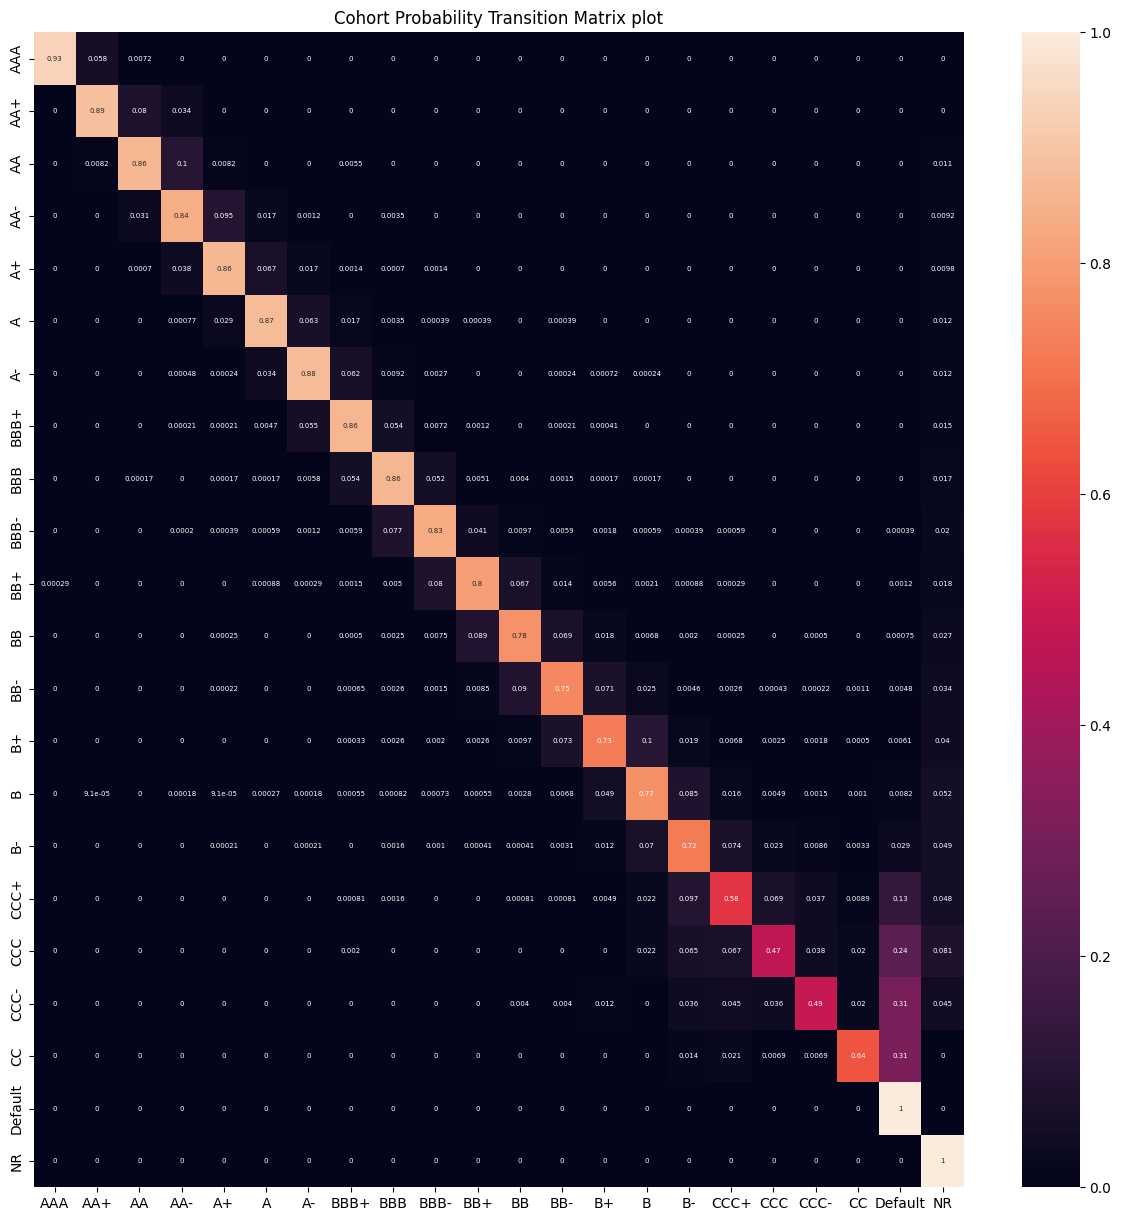

In [297]:
plt.figure(figsize=(15,15))
sns.heatmap(RatingMgrationCohortDF, annot=True, annot_kws={"fontsize":5})
plt.title("Cohort Probability Transition Matrix plot")
plt.show()

In [247]:
# All rows should add to ONE!
RatingMgrationCohortDF.sum(axis=1)

AAA        1.0
AA+        1.0
AA         1.0
AA-        1.0
A+         1.0
A          1.0
A-         1.0
BBB+       1.0
BBB        1.0
BBB-       1.0
BB+        1.0
BB         1.0
BB-        1.0
B+         1.0
B          1.0
B-         1.0
CCC+       1.0
CCC        1.0
CCC-       1.0
CC         1.0
Default    1.0
NR         1.0
dtype: float64

## The Transition Matrix for the Hazard Approach

In [248]:
#First add a zero row to the generator matrix
# Array to be added as row
row_to_be_added = np.zeros((22))
 # Adding row to numpy array
RatingMgrationHazard_V2 = np.vstack ((RatingMgrationHazard, row_to_be_added) )
# RatingMgrationHazard_V2[20,20] = 1.0 # Absorbing
pd.DataFrame(RatingMgrationHazard_V2)

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,-0.067363,0.059878,0.007485,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,-0.114943,0.080460,0.034483,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.008469,-0.141146,0.107271,0.008469,0.000000,0.000000,0.005646,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011292
3,0.000000,0.000000,0.032071,-0.161542,0.097400,0.017817,0.001188,0.000000,0.003563,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009502
4,0.000000,0.000000,0.000713,0.038503,-0.139039,0.068450,0.017825,0.001426,0.000713,0.001426,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009982
5,0.000000,0.000000,0.000000,0.000770,0.028473,-0.125049,0.062332,0.017314,0.003463,0.000385,...,0.000385,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011543
6,0.000000,0.000000,0.000000,0.000484,0.000242,0.034121,-0.121723,0.062193,0.009196,0.002662,...,0.000242,0.000726,0.000242,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011616
7,0.000000,0.000000,0.000000,0.000206,0.000206,0.004740,0.055434,-0.138689,0.054404,0.007213,...,0.000206,0.000412,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014631
8,0.000000,0.000000,0.000165,0.000000,0.000165,0.000165,0.005780,0.054334,-0.139717,0.051527,...,0.001486,0.000165,0.000165,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016680
9,0.000000,0.000000,0.000000,0.000201,0.000401,0.000602,0.001204,0.006018,0.078431,-0.168696,...,0.006018,0.001805,0.000602,0.000401,0.000602,0.000000,0.000000,0.000000,0.000401,0.020260


### Method1

In [249]:
#1 Calculate the maximum negative number of the generator, lmax
#2 Create a diagonal matrix with lmax as main diagonal
#3 Add the diagonal matrix in 2 to the generator to calcuate lStar
#4 Calculate the matrix exponential of (Lstar)
#5 Mutiply Exp(-1 * lmax) by the matrix in 4

In [250]:
#1
lmax = 0
for i in range(21):
    if (np.abs(RatingMgrationHazard[i, i]) > lmax):
        lmax = np.abs(RatingMgrationHazard[i, i])
print (lmax)

0.5234301729590611


In [251]:
#2
mat1 = np.zeros((22, 22))
np.fill_diagonal(mat1, lmax)

In [252]:
#3
Lstar = RatingMgrationHazard_V2 +  mat1

In [253]:
#4
tmp = la.expm(Lstar)

In [254]:
vec1 = np.zeros((22, 22))
np.fill_diagonal(vec1, np.exp(-lmax))

In [255]:
mexpgenerator = np.dot(vec1, tmp)

In [256]:
mexpgeneratorDF = pd.DataFrame(mexpgenerator)
# Change the column names
mexpgeneratorDF.columns =["AAA", "AA+", "AA", "AA-", "A+", "A", "A-", "BBB+",
                     "BBB", "BBB-", "BB+", "BB", "BB-", "B+", "B", "B-",
                     "CCC+", "CCC", "CCC-", "CC", 'Default', 'NR']

# Change the row indexes
mexpgeneratorDF.index = ["AAA", "AA+", "AA", "AA-", "A+", "A", "A-", "BBB+",
                     "BBB", "BBB-", "BB+", "BB", "BB-", "B+", "B", "B-",
                     "CCC+", "CCC", "CCC-", "CC", 'Default', 'NR']

#### Hazard Approach Transition Matrix

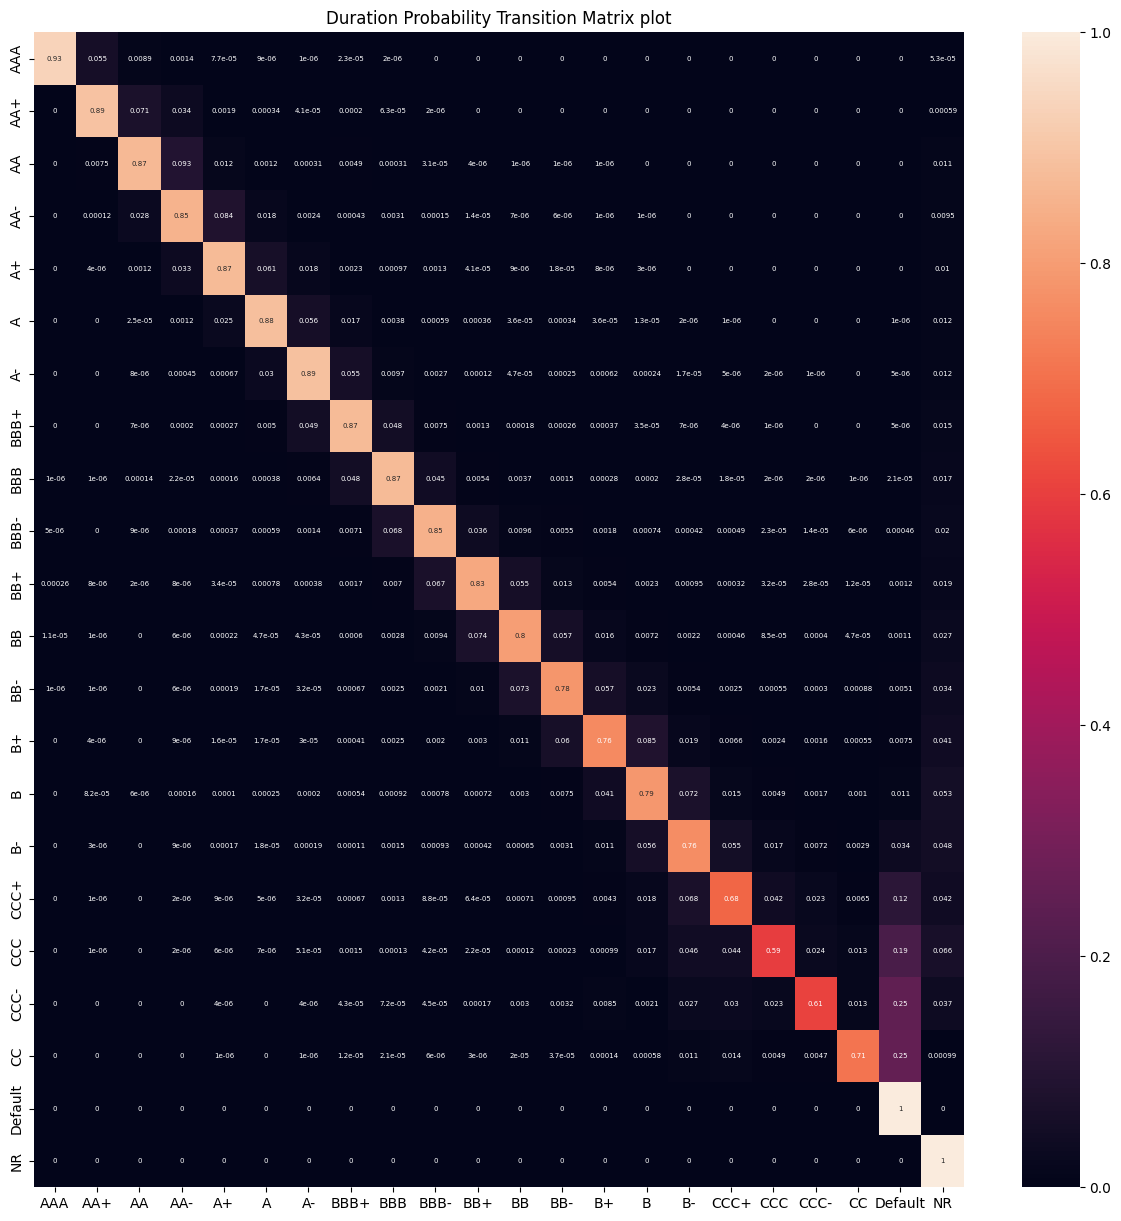

In [299]:
plt.figure(figsize=(15,15))
sns.heatmap(mexpgeneratorDF.round(6), annot=True, annot_kws={"fontsize":5})
plt.title("Duration Probability Transition Matrix plot")
plt.show()

In [257]:
# printing the data frame
mexpgeneratorDF.round(6)

,AAA,AA+,AA,AA-,A+,A,A-,BBB+,BBB,BBB-,...,BB-,B+,B,B-,CCC+,CCC,CCC-,CC,Default,NR
AAA,0.934856,0.054701,0.008923,0.001354,0.000077,0.000009,0.000001,0.000023,0.000002,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000053
AA+,0.000000,0.891720,0.071322,0.033834,0.001888,0.000335,0.000041,0.000205,0.000063,0.000002,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000590
AA,0.000000,0.007456,0.870152,0.092597,0.011899,0.001203,0.000311,0.004938,0.000306,0.000031,...,0.000001,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011100
AA-,0.000000,0.000118,0.027634,0.853928,0.084278,0.018394,0.002352,0.000434,0.003149,0.000147,...,0.000006,0.000001,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009538
A+,0.000000,0.000004,0.001155,0.033242,0.872682,0.060633,0.017628,0.002320,0.000965,0.001287,...,0.000018,0.000008,0.000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010003
A,0.000000,0.000000,0.000025,0.001160,0.025026,0.884307,0.055826,0.017020,0.003766,0.000585,...,0.000335,0.000036,0.000013,0.000002,0.000001,0.000000,0.000000,0.000000,0.000001,0.011501
A-,0.000000,0.000000,0.000008,0.000448,0.000670,0.030343,0.887898,0.055170,0.009724,0.002744,...,0.000252,0.000622,0.000239,0.000017,0.000005,0.000002,0.000001,0.000000,0.000005,0.011687
BBB+,0.000000,0.000000,0.000007,0.000197,0.000267,0.005011,0.049014,0.873374,0.047902,0.007524,...,0.000257,0.000374,0.000035,0.000007,0.000004,0.000001,0.000000,0.000000,0.000005,0.014523
BBB,0.000001,0.000001,0.000144,0.000022,0.000165,0.000382,0.006441,0.047658,0.872696,0.044614,...,0.001526,0.000284,0.000198,0.000028,0.000018,0.000002,0.000002,0.000001,0.000021,0.016601
BBB-,0.000005,0.000000,0.000009,0.000179,0.000369,0.000594,0.001446,0.007086,0.067605,0.847984,...,0.005549,0.001833,0.000739,0.000425,0.000493,0.000023,0.000014,0.000006,0.000461,0.019975


In [258]:
# and compare it with the cohort matrix
RatingMgrationCohortDF.round(6)

,AAA,AA+,AA,AA-,A+,A,A-,BBB+,BBB,BBB-,...,BB-,B+,B,B-,CCC+,CCC,CCC-,CC,Default,NR
AAA,0.934783,0.057971,0.007246,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AA+,0.000000,0.885057,0.080460,0.034483,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AA,0.000000,0.008197,0.863388,0.103825,0.008197,0.000000,0.000000,0.005464,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010929
AA-,0.000000,0.000000,0.031214,0.842775,0.094798,0.017341,0.001156,0.000000,0.003468,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009249
A+,0.000000,0.000000,0.000699,0.037762,0.863636,0.067133,0.017483,0.001399,0.000699,0.001399,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009790
A,0.000000,0.000000,0.000000,0.000772,0.028571,0.874517,0.062548,0.017375,0.003475,0.000386,...,0.000386,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011583
A-,0.000000,0.000000,0.000000,0.000483,0.000241,0.034017,0.878649,0.062002,0.009168,0.002654,...,0.000241,0.000724,0.000241,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011580
BBB+,0.000000,0.000000,0.000000,0.000206,0.000206,0.004734,0.055373,0.861466,0.054343,0.007205,...,0.000206,0.000412,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014615
BBB,0.000000,0.000000,0.000165,0.000000,0.000165,0.000165,0.005780,0.054335,0.860281,0.051528,...,0.001486,0.000165,0.000165,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016680
BBB-,0.000000,0.000000,0.000000,0.000197,0.000395,0.000592,0.001184,0.005919,0.077151,0.834057,...,0.005919,0.001776,0.000592,0.000395,0.000592,0.000000,0.000000,0.000000,0.000395,0.019929


In [301]:
res = pd.concat([RatingMgrationCohortDF["Default"], mexpgeneratorDF["Default"]], axis=1)
res.columns = ["Cohort", "Duration"]

In [303]:
res["Ratio"] = (res.Cohort/res.Duration)*100

In [305]:
res.drop(["Default", "NR"], axis=0, inplace=True)

In [306]:
res.to_csv("table1.csv")

In [308]:
res.index.name = "Rating"

In [310]:
res["Cohort"] = res["Cohort"] *10000
res["Duration"] = res["Duration"] *10000

In [313]:
res.round(3)

,Cohort,Duration,Ratio
Rating,,,
AAA,0.000,0.000,0.000
AA+,0.000,0.000,0.000
AA,0.000,0.000,0.000
AA-,0.000,0.000,0.000
A+,0.000,0.004,0.000
A,0.000,0.014,0.000
A-,0.000,0.050,0.000
BBB+,0.000,0.046,0.000
BBB,0.000,0.207,0.000


### Method 2 - Eigenvalues and Eigenvectors of the Generator Matrix

In [259]:
evals, evecs = la.eig(RatingMgrationHazard_V2)

In [260]:
size = len(evals)
arr1 = np.zeros((size, size))
np.fill_diagonal(arr1, np.real(evals))

In [261]:
Recunstructed = np.dot(np.dot(evecs,arr1),np.linalg.inv(evecs))

In [262]:
Recunstructed = pd.DataFrame(Recunstructed)
Recunstructed.columns =["AAA", "AA+", "AA", "AA-", "A+", "A", "A-", "BBB+",
                     "BBB", "BBB-", "BB+", "BB", "BB-", "B+", "B", "B-",
                     "CCC+", "CCC", "CCC-", "CC",  'Default', 'NR']
Recunstructed.index = ["AAA", "AA+", "AA", "AA-", "A+", "A", "A-", "BBB+",
                     "BBB", "BBB-", "BB+", "BB", "BB-", "B+", "B", "B-",
                     "CCC+", "CCC", "CCC-", "CC",  'Default', 'NR']

In [263]:
Recunstructed.round(6)

,AAA,AA+,AA,AA-,A+,A,A-,BBB+,BBB,BBB-,...,BB-,B+,B,B-,CCC+,CCC,CCC-,CC,Default,NR
AAA,-0.067363,0.059878,0.007485,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AA+,-0.000000,-0.114943,0.080460,0.034483,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000
AA,-0.000000,0.008469,-0.141146,0.107271,0.008469,-0.000000,-0.000000,0.005646,-0.000000,0.000000,...,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.011292
AA-,0.000000,-0.000000,0.032071,-0.161542,0.097400,0.017817,0.001188,0.000000,0.003563,0.000000,...,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.009502
A+,0.000000,-0.000000,0.000713,0.038503,-0.139039,0.068450,0.017825,0.001426,0.000713,0.001426,...,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.009982
A,-0.000000,-0.000000,0.000000,0.000770,0.028473,-0.125049,0.062332,0.017314,0.003463,0.000385,...,0.000385,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,0.011543
A-,0.000000,-0.000000,-0.000000,0.000484,0.000242,0.034121,-0.121723,0.062193,0.009196,0.002662,...,0.000242,0.000726,0.000242,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.011616
BBB+,-0.000000,-0.000000,-0.000000,0.000206,0.000206,0.004740,0.055434,-0.138689,0.054404,0.007213,...,0.000206,0.000412,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.014631
BBB,0.000000,-0.000000,0.000165,-0.000000,0.000165,0.000165,0.005780,0.054334,-0.139717,0.051527,...,0.001486,0.000165,0.000165,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.016680
BBB-,-0.000000,-0.000000,-0.000000,0.000201,0.000401,0.000602,0.001204,0.006018,0.078431,-0.168696,...,0.006018,0.001805,0.000602,0.000401,0.000602,0.000000,0.000000,0.000000,0.000401,0.020260


In [264]:
# and it is just the same original matrix
RatingMgrationHazardDF

,AAA,AA+,AA,AA-,A+,A,A-,BBB+,BBB,BBB-,...,BB-,B+,B,B-,CCC+,CCC,CCC-,CC,Default,NR
AAA,-0.067363,0.059878,0.007485,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AA+,0.000000,-0.114943,0.080460,0.034483,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AA,0.000000,0.008469,-0.141146,0.107271,0.008469,0.000000,0.000000,0.005646,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011292
AA-,0.000000,0.000000,0.032071,-0.161542,0.097400,0.017817,0.001188,0.000000,0.003563,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009502
A+,0.000000,0.000000,0.000713,0.038503,-0.139039,0.068450,0.017825,0.001426,0.000713,0.001426,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009982
A,0.000000,0.000000,0.000000,0.000770,0.028473,-0.125049,0.062332,0.017314,0.003463,0.000385,...,0.000385,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011543
A-,0.000000,0.000000,0.000000,0.000484,0.000242,0.034121,-0.121723,0.062193,0.009196,0.002662,...,0.000242,0.000726,0.000242,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011616
BBB+,0.000000,0.000000,0.000000,0.000206,0.000206,0.004740,0.055434,-0.138689,0.054404,0.007213,...,0.000206,0.000412,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014631
BBB,0.000000,0.000000,0.000165,0.000000,0.000165,0.000165,0.005780,0.054334,-0.139717,0.051527,...,0.001486,0.000165,0.000165,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016680
BBB-,0.000000,0.000000,0.000000,0.000201,0.000401,0.000602,0.001204,0.006018,0.078431,-0.168696,...,0.006018,0.001805,0.000602,0.000401,0.000602,0.000000,0.000000,0.000000,0.000401,0.020260


In [265]:
arr1 = np.zeros((size, size))
np.fill_diagonal(arr1, np.real(np.exp(evals)))
Recunstructed = np.dot(np.dot(evecs,arr1),np.linalg.inv(evecs))
Recunstructed = pd.DataFrame(Recunstructed)
Recunstructed.columns =["AAA", "AA+", "AA", "AA-", "A+", "A", "A-", "BBB+",
                     "BBB", "BBB-", "BB+", "BB", "BB-", "B+", "B", "B-",
                     "CCC+", "CCC", "CCC-", "CC", 'Default', 'NR']
Recunstructed.index = ["AAA", "AA+", "AA", "AA-", "A+", "A", "A-", "BBB+",
                     "BBB", "BBB-", "BB+", "BB", "BB-", "B+", "B", "B-",
                     "CCC+", "CCC", "CCC-", "CC",  'Default', 'NR']
Recunstructed.round(6)

,AAA,AA+,AA,AA-,A+,A,A-,BBB+,BBB,BBB-,...,BB-,B+,B,B-,CCC+,CCC,CCC-,CC,Default,NR
AAA,0.934856,0.054701,0.008923,0.001354,0.000077,0.000009,0.000001,0.000023,0.000002,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000053
AA+,0.000000,0.891720,0.071322,0.033834,0.001888,0.000335,0.000041,0.000205,0.000063,0.000002,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000590
AA,0.000000,0.007456,0.870152,0.092597,0.011899,0.001203,0.000311,0.004938,0.000306,0.000031,...,0.000001,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011100
AA-,0.000000,0.000118,0.027634,0.853928,0.084278,0.018394,0.002352,0.000434,0.003149,0.000147,...,0.000006,0.000001,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009538
A+,0.000000,0.000004,0.001155,0.033242,0.872682,0.060633,0.017628,0.002320,0.000965,0.001287,...,0.000018,0.000008,0.000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010003
A,0.000000,0.000000,0.000025,0.001160,0.025026,0.884307,0.055826,0.017020,0.003766,0.000585,...,0.000335,0.000036,0.000013,0.000002,0.000001,0.000000,0.000000,0.000000,0.000001,0.011501
A-,0.000000,0.000000,0.000008,0.000448,0.000670,0.030343,0.887898,0.055170,0.009724,0.002744,...,0.000252,0.000622,0.000239,0.000017,0.000005,0.000002,0.000001,0.000000,0.000005,0.011687
BBB+,0.000000,0.000000,0.000007,0.000197,0.000267,0.005011,0.049014,0.873374,0.047902,0.007524,...,0.000257,0.000374,0.000035,0.000007,0.000004,0.000001,0.000000,0.000000,0.000005,0.014523
BBB,0.000001,0.000001,0.000144,0.000022,0.000165,0.000382,0.006441,0.047658,0.872696,0.044614,...,0.001526,0.000284,0.000198,0.000028,0.000018,0.000002,0.000002,0.000001,0.000021,0.016601
BBB-,0.000005,0.000000,0.000009,0.000179,0.000369,0.000594,0.001446,0.007086,0.067605,0.847984,...,0.005549,0.001833,0.000739,0.000425,0.000493,0.000023,0.000014,0.000006,0.000461,0.019975


In [266]:
# and it is just the same as calculated with method 1
mexpgeneratorDF.round(6)

,AAA,AA+,AA,AA-,A+,A,A-,BBB+,BBB,BBB-,...,BB-,B+,B,B-,CCC+,CCC,CCC-,CC,Default,NR
AAA,0.934856,0.054701,0.008923,0.001354,0.000077,0.000009,0.000001,0.000023,0.000002,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000053
AA+,0.000000,0.891720,0.071322,0.033834,0.001888,0.000335,0.000041,0.000205,0.000063,0.000002,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000590
AA,0.000000,0.007456,0.870152,0.092597,0.011899,0.001203,0.000311,0.004938,0.000306,0.000031,...,0.000001,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011100
AA-,0.000000,0.000118,0.027634,0.853928,0.084278,0.018394,0.002352,0.000434,0.003149,0.000147,...,0.000006,0.000001,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009538
A+,0.000000,0.000004,0.001155,0.033242,0.872682,0.060633,0.017628,0.002320,0.000965,0.001287,...,0.000018,0.000008,0.000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010003
A,0.000000,0.000000,0.000025,0.001160,0.025026,0.884307,0.055826,0.017020,0.003766,0.000585,...,0.000335,0.000036,0.000013,0.000002,0.000001,0.000000,0.000000,0.000000,0.000001,0.011501
A-,0.000000,0.000000,0.000008,0.000448,0.000670,0.030343,0.887898,0.055170,0.009724,0.002744,...,0.000252,0.000622,0.000239,0.000017,0.000005,0.000002,0.000001,0.000000,0.000005,0.011687
BBB+,0.000000,0.000000,0.000007,0.000197,0.000267,0.005011,0.049014,0.873374,0.047902,0.007524,...,0.000257,0.000374,0.000035,0.000007,0.000004,0.000001,0.000000,0.000000,0.000005,0.014523
BBB,0.000001,0.000001,0.000144,0.000022,0.000165,0.000382,0.006441,0.047658,0.872696,0.044614,...,0.001526,0.000284,0.000198,0.000028,0.000018,0.000002,0.000002,0.000001,0.000021,0.016601
BBB-,0.000005,0.000000,0.000009,0.000179,0.000369,0.000594,0.001446,0.007086,0.067605,0.847984,...,0.005549,0.001833,0.000739,0.000425,0.000493,0.000023,0.000014,0.000006,0.000461,0.019975


## Multi period Transitions

In [267]:
RatingMgrationCohort_V2_year2 = np.dot(RatingMgrationCohort_V2, RatingMgrationCohort_V2)

RatingMgrationCohortDF_year2 = pd.DataFrame(RatingMgrationCohort_V2_year2)
RatingMgrationCohortDF_year2.columns =["AAA", "AA+", "AA", "AA-", "A+", "A", "A-", "BBB+",
                     "BBB", "BBB-", "BB+", "BB", "BB-", "B+", "B", "B-",
                     "CCC+", "CCC", "CCC-", "CC", 'Default', 'NR']
RatingMgrationCohortDF_year2.index = ["AAA", "AA+", "AA", "AA-", "A+", "A", "A-", "BBB+",
                     "BBB", "BBB-", "BB+", "BB", "BB-", "B+", "B", "B-",
                     "CCC+", "CCC", "CCC-", "CC", 'Default', 'NR']

mexpgenerator_year2 = np.dot(mexpgenerator, mexpgenerator)

mexpgenerator_year2DF_year2 = pd.DataFrame(mexpgenerator_year2)
mexpgenerator_year2DF_year2.columns =["AAA", "AA+", "AA", "AA-", "A+", "A", "A-", "BBB+",
                     "BBB", "BBB-", "BB+", "BB", "BB-", "B+", "B", "B-",
                     "CCC+", "CCC", "CCC-", "CC", 'Default', 'NR']
mexpgenerator_year2DF_year2.index = ["AAA", "AA+", "AA", "AA-", "A+", "A", "A-", "BBB+",
                     "BBB", "BBB-", "BB+", "BB", "BB-", "B+", "B", "B-",
                     "CCC+", "CCC", "CCC-", "CC", 'Default', 'NR']

### 2 year Transition Matrix - Hazard Approach

In [268]:
mexpgenerator_year2DF_year2

,AAA,AA+,AA,AA-,A+,A,A-,BBB+,BBB,BBB-,...,BB-,B+,B,B-,CCC+,CCC,CCC-,CC,Default,NR
AAA,8.739562e-01,9.998202e-02,2.004537e-02,5.100869e-03,0.000464,7.594434e-05,0.000014,0.000098,0.000015,0.000001,...,4.247954e-08,3.100474e-08,5.011884e-09,7.885287e-10,4.806045e-10,6.324799e-11,4.442685e-11,2.945888e-11,5.442307e-10,0.000247
AA+,2.941393e-10,7.957002e-01,1.265971e-01,6.572927e-02,0.007040,1.419037e-03,0.000237,0.000743,0.000252,0.000019,...,7.594788e-07,3.497431e-07,8.927199e-08,1.314633e-08,8.139657e-09,9.742456e-10,7.044136e-10,5.334072e-10,9.392463e-09,0.002259
AA,3.285750e-09,1.314792e-02,7.602698e-01,1.602944e-01,0.028588,4.572325e-03,0.001286,0.008731,0.001083,0.000134,...,4.849115e-06,4.316509e-06,7.240566e-07,1.386054e-07,8.006664e-08,1.199848e-08,8.135973e-09,4.991346e-09,9.553327e-08,0.021860
AA-,1.051137e-08,4.129457e-04,4.774950e-02,7.345794e-01,0.146306,3.719134e-02,0.006660,0.001675,0.005651,0.000521,...,2.491882e-05,6.756905e-06,3.137628e-06,4.915673e-07,3.005003e-07,3.513994e-08,2.561949e-08,2.151903e-08,3.658733e-07,0.019134
A+,2.960653e-08,1.990037e-05,2.932858e-03,5.758216e-02,0.765919,1.076926e-01,0.034621,0.006130,0.002388,0.002367,...,6.584906e-05,3.126587e-05,1.233016e-05,2.245091e-06,1.630250e-06,1.734415e-07,1.023872e-07,7.389713e-08,1.802094e-06,0.020044
A,1.991066e-07,5.636468e-07,1.061583e-04,2.878540e-03,0.044111,7.853193e-01,0.100238,0.033240,0.008046,0.001521,...,5.951547e-04,1.246838e-04,4.858914e-05,8.012049e-06,3.469587e-06,7.341613e-07,4.260772e-07,6.819654e-07,6.174430e-06,0.022929
A-,8.692698e-08,2.094282e-07,2.972358e-05,8.501636e-04,0.001994,5.410437e-02,0.792841,0.098171,0.020067,0.005641,...,5.178260e-04,1.079006e-03,4.671102e-04,6.135761e-05,1.963836e-05,5.722866e-06,3.115417e-06,1.679324e-06,2.187680e-05,0.023494
BBB+,7.563223e-07,1.798680e-07,2.555647e-05,3.791851e-04,0.000652,1.033804e-02,0.086931,0.767911,0.084656,0.015319,...,6.041467e-04,6.941938e-04,1.282386e-04,3.013106e-05,1.567070e-05,2.844593e-06,1.884036e-06,1.060013e-06,2.061691e-05,0.028843
BBB,3.086935e-06,2.316816e-06,2.525781e-04,7.679639e-05,0.000335,1.146192e-03,0.013768,0.083906,0.767015,0.077548,...,3.089043e-03,7.527938e-04,4.661673e-04,1.080934e-04,6.429442e-05,7.598467e-06,6.557231e-06,4.056996e-06,8.651828e-05,0.033034
BBB-,1.894496e-05,1.073449e-06,3.005282e-05,3.220342e-04,0.000684,1.187910e-03,0.003348,0.015581,0.116980,0.724648,...,1.028026e-02,3.670973e-03,1.690795e-03,8.950787e-04,8.320569e-04,7.486850e-05,4.655642e-05,2.252527e-05,1.038672e-03,0.039435


### 2 year Transition Matrix - Cohort Approach

In [269]:
RatingMgrationCohortDF_year2

,AAA,AA+,AA,AA-,A+,A,A-,BBB+,BBB,BBB-,...,BB-,B+,B,B-,CCC+,CCC,CCC-,CC,Default,NR
AAA,8.738185e-01,1.055574e-01,1.769456e-02,0.002751,0.000059,0.000000,0.000000,0.000040,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000079
AA+,0.000000e+00,7.839862e-01,1.417559e-01,0.067934,0.003928,0.000598,0.000040,0.000440,0.000120,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.001198
AA,0.000000e+00,1.433152e-02,7.493448e-01,0.177736,0.023999,0.002377,0.000566,0.009437,0.000663,0.000051,...,0.000001,0.000002,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.021485
AA-,0.000000e+00,2.558514e-04,5.332281e-02,0.717103,0.162516,0.036184,0.004752,0.000865,0.006044,0.000321,...,0.000012,0.000001,8.516911e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.018584
A+,0.000000e+00,5.731973e-06,2.386531e-03,0.064571,0.751377,0.117944,0.034785,0.004713,0.001914,0.002493,...,0.000040,0.000016,5.161129e-06,5.519343e-07,8.279014e-07,0.000000e+00,0.000000e+00,0.000000e+00,5.519343e-07,0.019642
A,1.133589e-07,0.000000e+00,4.465729e-05,0.002439,0.049754,0.768923,0.111141,0.034272,0.007601,0.001201,...,0.000660,0.000083,2.630923e-05,2.249729e-06,1.346073e-06,1.673604e-07,8.368019e-08,4.184009e-07,2.446768e-06,0.023063
A-,0.000000e+00,2.202634e-08,1.674375e-05,0.000879,0.001453,0.059959,0.777646,0.108997,0.019639,0.005480,...,0.000504,0.001225,4.811379e-04,3.627127e-05,1.097660e-05,3.087267e-06,1.719773e-06,8.623812e-07,8.603371e-06,0.023318
BBB+,3.626178e-07,0.000000e+00,1.554415e-05,0.000390,0.000535,0.010134,0.096978,0.748636,0.094654,0.015265,...,0.000518,0.000738,7.670153e-05,1.255229e-05,7.950880e-06,1.109276e-06,7.926498e-07,4.270767e-07,7.791265e-06,0.029001
BBB,1.503152e-06,1.368790e-06,2.847842e-04,0.000048,0.000325,0.000787,0.013136,0.094230,0.747105,0.088155,...,0.003074,0.000593,3.923466e-04,5.675214e-05,4.063632e-05,1.867717e-06,2.850277e-06,1.858424e-06,3.878091e-05,0.033188
BBB-,1.210779e-05,5.404451e-08,1.917664e-05,0.000348,0.000724,0.001159,0.002858,0.014384,0.131307,0.703064,...,0.010878,0.003652,1.482991e-03,8.390180e-04,9.152177e-04,5.959677e-05,3.565809e-05,1.445523e-05,9.139631e-04,0.039309


### However, with the generator, as estimated with the hazard approach, we are no longer restricted to integer years!!!

In [270]:
# Let's prepare a simple function to do just this!
def FutureTransition(Matrix, time):
    # Time is the future date. It can be 2 (for 2 years), or 1.5 (for 18 months)
    # Matrix is the Generator matrix, M by M matrix, a square matrix!

    evals, evecs = la.eig(Matrix) # it calculate eigenvalues and eigenvectors
    size = len(evals)
    arr1 = np.zeros((size, size))

    np.fill_diagonal(arr1, np.exp(time*np.real(evals)))

    FutMatrix = np.dot(np.dot(evecs,arr1),np.linalg.inv(evecs))
    FutMatrix = pd.DataFrame(FutMatrix)
    FutMatrix.columns = ["AAA", "AA+", "AA", "AA-", "A+", "A", "A-", "BBB+",
                     "BBB", "BBB-", "BB+", "BB", "BB-", "B+", "B", "B-",
                     "CCC+", "CCC", "CCC-", "CC", 'Default', 'NR']
    FutMatrix.index   = ["AAA", "AA+", "AA", "AA-", "A+", "A", "A-", "BBB+",
                     "BBB", "BBB-", "BB+", "BB", "BB-", "B+", "B", "B-",
                     "CCC+", "CCC", "CCC-", "CC", 'Default', 'NR']

    return FutMatrix.round(6)

In [271]:
# so using the generator over ONE year, we should recover the ONE YEAR transition Matrix.
# and INDEED!!
FutureTransition(RatingMgrationHazard_V2,1)

,AAA,AA+,AA,AA-,A+,A,A-,BBB+,BBB,BBB-,...,BB-,B+,B,B-,CCC+,CCC,CCC-,CC,Default,NR
AAA,0.934856,0.054701,0.008923,0.001354,0.000077,0.000009,0.000001,0.000023,0.000002,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000053
AA+,0.000000,0.891720,0.071322,0.033834,0.001888,0.000335,0.000041,0.000205,0.000063,0.000002,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000590
AA,0.000000,0.007456,0.870152,0.092597,0.011899,0.001203,0.000311,0.004938,0.000306,0.000031,...,0.000001,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011100
AA-,0.000000,0.000118,0.027634,0.853928,0.084278,0.018394,0.002352,0.000434,0.003149,0.000147,...,0.000006,0.000001,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009538
A+,0.000000,0.000004,0.001155,0.033242,0.872682,0.060633,0.017628,0.002320,0.000965,0.001287,...,0.000018,0.000008,0.000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010003
A,0.000000,0.000000,0.000025,0.001160,0.025026,0.884307,0.055826,0.017020,0.003766,0.000585,...,0.000335,0.000036,0.000013,0.000002,0.000001,0.000000,0.000000,0.000000,0.000001,0.011501
A-,0.000000,0.000000,0.000008,0.000448,0.000670,0.030343,0.887898,0.055170,0.009724,0.002744,...,0.000252,0.000622,0.000239,0.000017,0.000005,0.000002,0.000001,0.000000,0.000005,0.011687
BBB+,0.000000,0.000000,0.000007,0.000197,0.000267,0.005011,0.049014,0.873374,0.047902,0.007524,...,0.000257,0.000374,0.000035,0.000007,0.000004,0.000001,0.000000,0.000000,0.000005,0.014523
BBB,0.000001,0.000001,0.000144,0.000022,0.000165,0.000382,0.006441,0.047658,0.872696,0.044614,...,0.001526,0.000284,0.000198,0.000028,0.000018,0.000002,0.000002,0.000001,0.000021,0.016601
BBB-,0.000005,0.000000,0.000009,0.000179,0.000369,0.000594,0.001446,0.007086,0.067605,0.847984,...,0.005549,0.001833,0.000739,0.000425,0.000493,0.000023,0.000014,0.000006,0.000461,0.019975


In [272]:
# Over 2 years
FutureTransition(RatingMgrationHazard_V2,2)

,AAA,AA+,AA,AA-,A+,A,A-,BBB+,BBB,BBB-,...,BB-,B+,B,B-,CCC+,CCC,CCC-,CC,Default,NR
AAA,0.873956,0.099982,0.020045,0.005101,0.000464,0.000076,0.000014,0.000098,0.000015,0.000001,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000247
AA+,0.000000,0.795700,0.126597,0.065729,0.007040,0.001419,0.000237,0.000743,0.000252,0.000019,...,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002259
AA,0.000000,0.013148,0.760270,0.160294,0.028588,0.004572,0.001286,0.008731,0.001083,0.000134,...,0.000005,0.000004,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.021860
AA-,0.000000,0.000413,0.047750,0.734579,0.146306,0.037191,0.006660,0.001675,0.005651,0.000521,...,0.000025,0.000007,0.000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019134
A+,0.000000,0.000020,0.002933,0.057582,0.765919,0.107693,0.034621,0.006130,0.002388,0.002367,...,0.000066,0.000031,0.000012,0.000002,0.000002,0.000000,0.000000,0.000000,0.000002,0.020044
A,0.000000,0.000001,0.000106,0.002879,0.044111,0.785319,0.100238,0.033240,0.008046,0.001521,...,0.000595,0.000125,0.000049,0.000008,0.000003,0.000001,0.000000,0.000001,0.000006,0.022929
A-,0.000000,0.000000,0.000030,0.000850,0.001994,0.054104,0.792841,0.098171,0.020067,0.005641,...,0.000518,0.001079,0.000467,0.000061,0.000020,0.000006,0.000003,0.000002,0.000022,0.023494
BBB+,0.000001,0.000000,0.000026,0.000379,0.000652,0.010338,0.086931,0.767911,0.084656,0.015319,...,0.000604,0.000694,0.000128,0.000030,0.000016,0.000003,0.000002,0.000001,0.000021,0.028843
BBB,0.000003,0.000002,0.000253,0.000077,0.000335,0.001146,0.013768,0.083906,0.767015,0.077548,...,0.003089,0.000753,0.000466,0.000108,0.000064,0.000008,0.000007,0.000004,0.000087,0.033034
BBB-,0.000019,0.000001,0.000030,0.000322,0.000684,0.001188,0.003348,0.015581,0.116980,0.724648,...,0.010280,0.003671,0.001691,0.000895,0.000832,0.000075,0.000047,0.000023,0.001039,0.039435


In [273]:
FutureTransition(RatingMgrationHazard_V2,1.5)

,AAA,AA+,AA,AA-,A+,A,A-,BBB+,BBB,BBB-,...,BB-,B+,B,B-,CCC+,CCC,CCC-,CC,Default,NR
AAA,0.903893,0.078436,0.014268,0.002957,0.000220,0.000032,0.000005,0.000054,0.000007,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000129
AA+,0.000000,0.842272,0.100771,0.050074,0.004103,0.000777,0.000113,0.000438,0.000142,0.000008,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001299
AA,0.000000,0.010500,0.812944,0.129177,0.019816,0.002640,0.000713,0.006954,0.000647,0.000073,...,0.000002,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016519
AA-,0.000000,0.000249,0.038515,0.791275,0.117731,0.027803,0.004294,0.000959,0.004466,0.000311,...,0.000014,0.000003,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014330
A+,0.000000,0.000010,0.001987,0.046387,0.816981,0.085682,0.026223,0.004064,0.001624,0.001847,...,0.000039,0.000018,0.000007,0.000001,0.000001,0.000000,0.000000,0.000000,0.000001,0.015019
A,0.000000,0.000000,0.000058,0.001967,0.035229,0.832901,0.079320,0.025247,0.005851,0.001013,...,0.000473,0.000075,0.000028,0.000004,0.000002,0.000000,0.000000,0.000000,0.000003,0.017224
A-,0.000000,0.000000,0.000017,0.000653,0.001267,0.042962,0.838430,0.078029,0.014854,0.004175,...,0.000383,0.000868,0.000355,0.000037,0.000012,0.000003,0.000002,0.000001,0.000012,0.017578
BBB+,0.000000,0.000000,0.000015,0.000289,0.000446,0.007653,0.069209,0.818254,0.067513,0.011416,...,0.000420,0.000539,0.000076,0.000017,0.000009,0.000002,0.000001,0.000001,0.000011,0.021707
BBB,0.000002,0.000001,0.000202,0.000046,0.000249,0.000721,0.010030,0.067042,0.817428,0.062358,...,0.002306,0.000499,0.000323,0.000062,0.000038,0.000004,0.000004,0.000002,0.000048,0.024840
BBB-,0.000011,0.000000,0.000018,0.000254,0.000533,0.000889,0.002344,0.011217,0.094280,0.783131,...,0.008007,0.002756,0.001193,0.000655,0.000677,0.000047,0.000029,0.000013,0.000736,0.029765


# Confidence Intervals

### Cohort

In [274]:
TransitionData.Date = pd.to_datetime(TransitionData.Date)
TransitionData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77579 entries, 0 to 77578
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Id            77579 non-null  int64         
 1   Date          77579 non-null  datetime64[ns]
 2   RatingSymbol  77579 non-null  object        
 3   RatingNumber  77579 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 3.0+ MB


In [275]:
## compute number of firm-years for cohort method
TransitionData["Year"] = TransitionData.Date.dt.year
# TransitionData.groupby("Year")[["RatingSymbol", "Date", "Id"]].agg({"RatingSymbol":"first", "Date":np.min, ""})

In [276]:
first_rating_by_year_and_date = TransitionData.groupby(["Year", "Id"], as_index=False)["RatingSymbol"].first()
first_rating_by_year_and_date

,Year,Id,RatingSymbol
0,2008,908,BBB+
1,2009,1200,A-
2,2009,4641,A-
3,2009,5289,BBB-
4,2009,5673,B+
...,...,...,...
50852,2021,8516,B-
50853,2021,8517,B-
50854,2021,8518,B-
50855,2021,8521,B


In [277]:
# Correct the NR using pij
NR = first_rating_by_year_and_date.RatingSymbol.value_counts()
NR

B       8390
BBB     4827
B+      4717
BBB-    4065
B-      4044
BBB+    3913
BB-     3650
A-      3494
BB      3089
BB+     2708
A       2115
CCC+    1218
NR      1172
A+      1122
AA-      759
CCC      471
AA       291
D        246
CCC-     245
CC       143
AAA      115
AA+       63
Name: RatingSymbol, dtype: int64

#### Wald CI

In [278]:
def compute_ci_wald(pd, nr,alpha=0.05):
  ## compute z_alpha
  z_alpha = stats.norm.ppf(1-alpha/2)

  ## compute the standard error
  se = np.sqrt(pd*(1-pd)/nr)

  ## compute the confidence interval
  ci = pd - z_alpha*se, pd + z_alpha*se

  return ci

In [279]:
wald_ci_raw = RatingMgrationCohortDF[["Default"]].join(NR).rename(columns={"RatingSymbol":"NR"}).apply(lambda x:\
                                                                                                      compute_ci_wald(x.values[0], x.values[1]),
                                                                                                      axis=1)
wald_ci_df = pd.DataFrame(wald_ci_raw.tolist(), columns = ["lower", "upper"], index=wald_ci_raw.index)
wald_ci_df.drop(["Default", "NR"], axis=0, inplace=True)
wald_ci_df

,lower,upper
AAA,0.000000,0.000000
AA+,0.000000,0.000000
AA,0.000000,0.000000
AA-,0.000000,0.000000
A+,0.000000,0.000000
A,0.000000,0.000000
A-,0.000000,0.000000
BBB+,0.000000,0.000000
BBB,0.000000,0.000000
BBB-,-0.000216,0.001005


In [317]:
(wald_ci_df*10000).round(3)

,lower,upper
AAA,0.000,0.000
AA+,0.000,0.000
AA,0.000,0.000
AA-,0.000,0.000
A+,0.000,0.000
A,0.000,0.000
A-,0.000,0.000
BBB+,0.000,0.000
BBB,0.000,0.000
BBB-,-2.159,10.052


In [315]:
(wald_ci_df*10000).to_csv("wald_ci.csv")

In [316]:
# prompt: download wald_ci.csv from drive

from google.colab import files
files.download("wald_ci.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Agresti and Coul CI

In [280]:
def compute_ci_agresti(pd,nr, alpha=0.05):
  ## compute z_alpha
  z_alpha = stats.norm.ppf(1-alpha/2)

  ## compute the number of people who migrated from rating to default
  nrd = nr * pd

  ## compute the corrected nr and nrd
  nr_tilde = nr + z_alpha**2
  nrd_tilde = nrd + z_alpha**2/2

  ## compute the corrected probability
  pd_tilde = nrd_tilde/nr_tilde

  ## compute the standard error
  se = np.sqrt(pd_tilde*(1-pd_tilde)/nr_tilde)

  ## compute the confidence interval
  ci = pd_tilde - z_alpha*se, pd_tilde + z_alpha*se

  return ci


In [281]:
agresti_ci_raw = RatingMgrationCohortDF[["Default"]].join(NR).rename(columns={"RatingSymbol":"NR"}).drop(["Default", "NR"], axis=0).apply(lambda x:\
                                                                                                      compute_ci_agresti(x.values[0], x.values[1]),
                                                                                                      axis=1)
agresti_ci_df = pd.DataFrame(agresti_ci_raw.tolist(), columns = ["lower", "upper"], index=agresti_ci_raw.index)
# agresti_ci_df.drop(["Default", "NR"], axis=0, inplace=True)
agresti_ci_df

,lower,upper
AAA,-0.006509,0.038833
AA+,-0.011315,0.068786
AA,-0.002668,0.015697
AA-,-0.001038,0.006074
A+,-0.000705,0.004117
A,-0.000375,0.002188
A-,-0.000227,0.001325
BBB+,-0.000203,0.001184
BBB,-0.000165,0.000960
BBB-,-0.000038,0.001770


In [318]:
(agresti_ci_df*10000).to_csv("agresti_ci.csv")
# prompt: download wald_ci.csv from drive

from google.colab import files
files.download("agresti_ci.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Clopper Pearson CI

In [282]:
def compute_ci_clopper(pd,nr, alpha=0.05):
  ## compute nrd
  nrd = int(nr * pd)

  ## binomial test
  result = stats.binomtest(k=nrd, n=int(nr), p=pd)

  ## compute the confidence interval
  ci = result.proportion_ci(method="exact", confidence_level=1-alpha)

  return ci.low, ci.high

In [283]:
RatingMgrationCohortDF[["Default"]].join(NR).rename(columns={"RatingSymbol":"NR"}).drop(["Default", "NR"], axis=0).head()

,Default,NR
AAA,0.0,115.0
AA+,0.0,63.0
AA,0.0,291.0
AA-,0.0,759.0
A+,0.0,1122.0


In [284]:
clopper_ci_raw = RatingMgrationCohortDF[["Default"]].join(NR).rename(columns={"RatingSymbol":"NR"}).drop(["Default", "NR"], axis=0).apply(lambda x:\
                                                                                                      compute_ci_clopper(x.values[0], x.values[1]),
                                                                                                      axis=1)
clopper_ci_df = pd.DataFrame(clopper_ci_raw.tolist(), columns = ["lower", "upper"], index=clopper_ci_raw.index)
# clopper_ci_df.drop(["Default", "NR"], axis=0, inplace=True)
clopper_ci_df

,lower,upper
AAA,0.000000,0.031568
AA+,0.000000,0.056872
AA,0.000000,0.012597
AA-,0.000000,0.004848
A+,0.000000,0.003282
A,0.000000,0.001743
A-,0.000000,0.001055
BBB+,0.000000,0.000942
BBB,0.000000,0.000764
BBB-,0.000006,0.001370


In [319]:
(clopper_ci_df*10000).to_csv("clopper_ci.csv")
# prompt: download wald_ci.csv from drive

from google.colab import files
files.download("clopper_ci.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Hazard

In [285]:
mexpgeneratorDF#.round(6)

,AAA,AA+,AA,AA-,A+,A,A-,BBB+,BBB,BBB-,...,BB-,B+,B,B-,CCC+,CCC,CCC-,CC,Default,NR
AAA,9.348562e-01,5.470088e-02,8.923230e-03,1.353589e-03,0.000077,9.430527e-06,0.000001,0.000023,0.000002,1.097178e-07,...,3.391413e-09,3.337178e-09,2.868352e-10,3.697644e-11,2.381605e-11,2.922813e-12,2.093177e-12,1.312338e-12,2.464081e-11,0.000053
AA+,1.800522e-11,8.917199e-01,7.132181e-02,3.383380e-02,0.001888,3.345088e-04,0.000041,0.000205,0.000063,2.463580e-06,...,9.157154e-08,4.169523e-08,8.237927e-09,7.988854e-10,5.359292e-10,5.261453e-11,4.055514e-11,3.219566e-11,5.587963e-10,0.000590
AA,3.770572e-10,7.456223e-03,8.701525e-01,9.259665e-02,0.011899,1.203109e-03,0.000311,0.004938,0.000306,3.064507e-05,...,9.156980e-07,1.099652e-06,9.365454e-08,1.536448e-08,9.543205e-09,1.296064e-09,9.012610e-10,5.266123e-10,1.015154e-08,0.011100
AA-,1.282305e-09,1.183213e-04,2.763377e-02,8.539277e-01,0.084278,1.839405e-02,0.002352,0.000434,0.003149,1.466310e-04,...,6.248161e-06,1.261510e-06,6.143572e-07,6.026765e-08,4.085003e-08,3.525136e-09,2.851346e-09,2.651636e-09,4.383870e-08,0.009538
A+,4.058036e-09,4.167024e-06,1.154513e-03,3.324214e-02,0.872682,6.063333e-02,0.017628,0.002320,0.000965,1.287323e-03,...,1.820142e-05,7.996766e-06,2.892784e-06,4.297904e-07,4.126136e-07,2.366113e-08,1.393443e-08,1.021071e-08,3.660374e-07,0.010003
A,5.258748e-08,6.903702e-08,2.513709e-05,1.159654e-03,0.025026,8.843072e-01,0.055826,0.017020,0.003766,5.851234e-04,...,3.350819e-04,3.598816e-05,1.273360e-05,1.630640e-06,7.851540e-07,1.399762e-07,7.903914e-08,1.884416e-07,1.385508e-06,0.011501
A-,1.158475e-08,3.371618e-08,7.956863e-06,4.480274e-04,0.000670,3.034274e-02,0.887898,0.055170,0.009724,2.743817e-03,...,2.516708e-04,6.221999e-04,2.392440e-04,1.717752e-05,5.333562e-06,1.534412e-06,8.406622e-07,4.378654e-07,5.025314e-06,0.011687
BBB+,1.854817e-07,2.465100e-08,7.073557e-06,1.965355e-04,0.000267,5.010692e-03,0.049014,0.873374,0.047902,7.524395e-03,...,2.568983e-04,3.739754e-04,3.545703e-05,7.132402e-06,4.009057e-06,6.546328e-07,4.470913e-07,2.455242e-07,4.584646e-06,0.014523
BBB,7.684467e-07,6.375686e-07,1.439866e-04,2.153805e-05,0.000165,3.815536e-04,0.006441,0.047658,0.872696,4.461366e-02,...,1.525702e-03,2.836504e-04,1.981846e-04,2.811870e-05,1.815176e-05,1.543632e-06,1.582658e-06,9.951213e-07,2.073328e-05,0.016601
BBB-,5.388836e-06,1.650802e-07,8.579904e-06,1.787635e-04,0.000369,5.936814e-04,0.001446,0.007086,0.067605,8.479835e-01,...,5.549076e-03,1.833341e-03,7.385043e-04,4.254748e-04,4.933556e-04,2.313305e-05,1.418976e-05,6.399336e-06,4.613068e-04,0.019975


#### Parametric

In [286]:
def compute_parametric_bootstrap_ci(pd, nr, alpha=0.05):
  pass

#### Non parametric

In [287]:
TransitionData.Year.value_counts().sort_index()

2008       1
2009       9
2010    1689
2011    5633
2012    6877
2013    7211
2014    7415
2015    8604
2016    8692
2017    8396
2018    7856
2019    5219
2020    6923
2021    3054
Name: Year, dtype: int64

In [288]:
pij = pd.read_csv("pij.csv")

In [289]:
ratings = ["AAA", "AA+", "AA", "AA-", "A+", "A", "A-", "BBB+",
                     "BBB", "BBB-", "BB+", "BB", "BB-", "B+", "B", "B-",
                     "CCC+", "CCC", "CCC-", "CC", 'Default', 'NR']

In [290]:
pij.drop("Unnamed: 0", axis=1, inplace=True)

In [291]:
pij

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,129.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,77.0,7.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,3.0,316.0,38.0,3.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
3,0.0,0.0,27.0,729.0,82.0,15.0,1.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
4,0.0,0.0,1.0,54.0,1235.0,96.0,25.0,2.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0
5,0.0,0.0,0.0,2.0,74.0,2265.0,162.0,45.0,9.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0
6,0.0,0.0,0.0,2.0,1.0,141.0,3642.0,257.0,38.0,11.0,...,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,48.0
7,0.0,0.0,0.0,1.0,1.0,23.0,269.0,4185.0,264.0,35.0,...,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71.0
8,0.0,0.0,1.0,0.0,1.0,1.0,35.0,329.0,5209.0,312.0,...,9.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,101.0
9,0.0,0.0,0.0,1.0,2.0,3.0,6.0,30.0,391.0,4227.0,...,30.0,9.0,3.0,2.0,3.0,0.0,0.0,0.0,2.0,101.0


In [292]:
pij.index=ratings[:-1]
pij.columns=ratings

In [293]:
pij.drop("Default", axis=0, inplace=True)

In [294]:
pij = pij.astype(int)

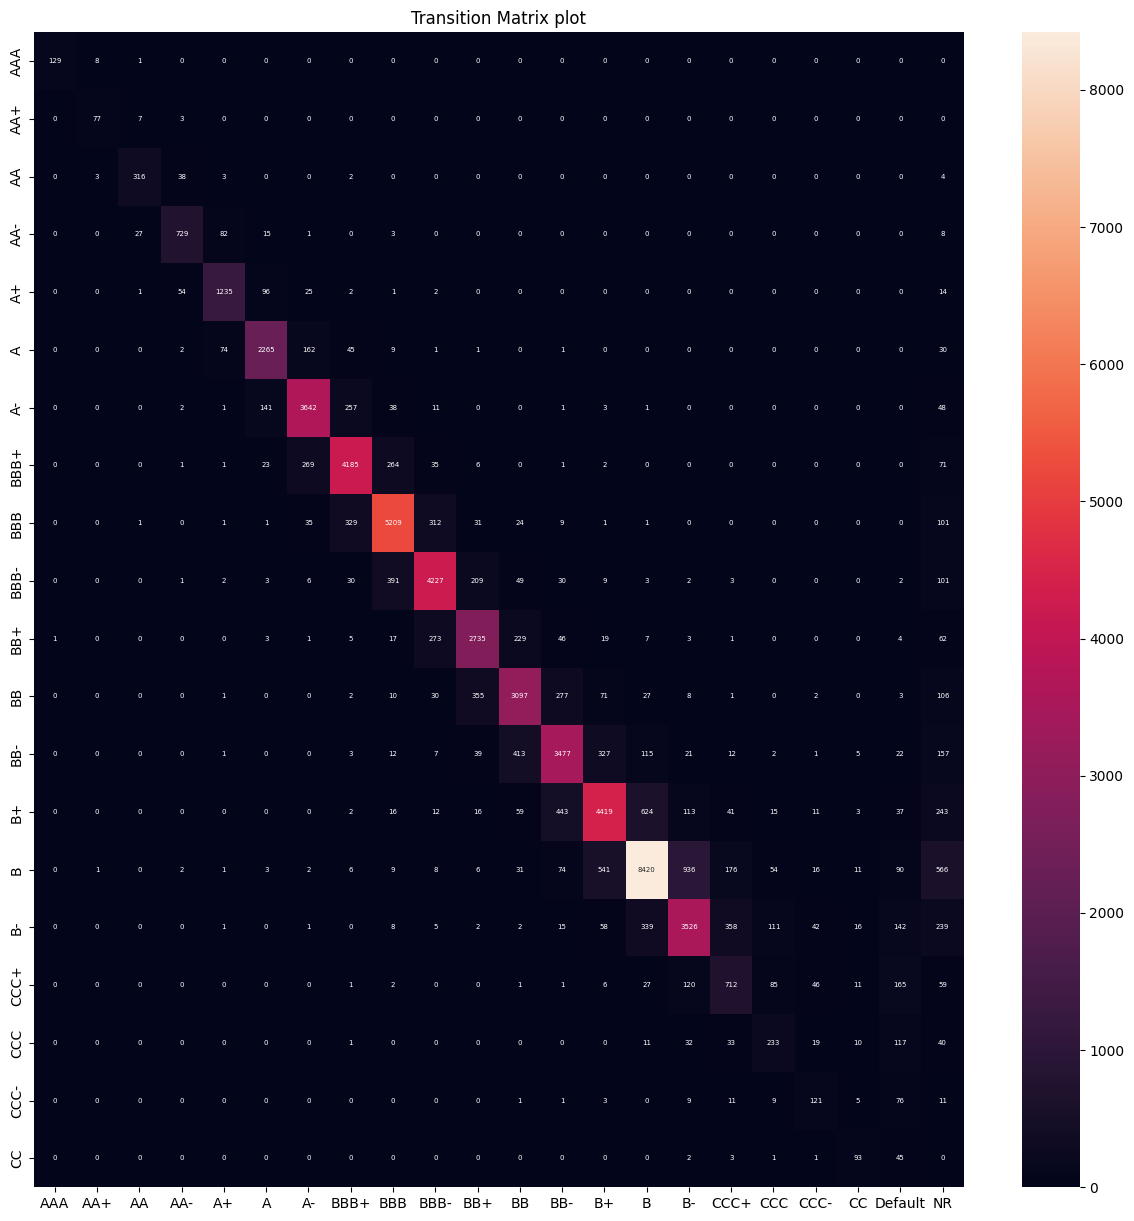

In [295]:
plt.figure(figsize=(15,15))
sns.heatmap(pij, annot=True, annot_kws={"fontsize":5}, fmt="d")
plt.title("Transition Matrix plot")
plt.show()